In [1]:
import numpy as np

import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("bright")

import re
import unicodedata
from collections import Counter
import sqlite3
import plotly.express as px

from nlp_utils import get_english_stopwords, get_corpus_stopwords
from nlp_utils import CONTRACTION_MAP, CONVERSATIONAL_ABBREVIATION_MAP
from nlp_utils import print_completion_message
from nlp_utils import plot_label_frequencies, plot_document_frequencies, average_token_length
from nlp_utils import plot_confusion_matrices, plot_validation_curve, plot_validation_metrics_by_label, get_classification_metrics
from nlp_utils import plot_history
from nlp_utils import regex_scan

from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, Bidirectional, LSTM 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

# A. *Business Understanding*

*Gallup*, a global analytics and advice firm, plans to  In addition to having some sample of the population complete a questionnaire, the company has decided to utilize Twitter as an alternative source of sentiment data. The company wishes to develop this as an alternative approach to polling mainly due to its efficiency; a far greater amount of data can be obtained in a fraction of the time compared to having some portion of the population complete a questionnaire. Additionally, the sheer amount of discussion relating to American politics on Twitter means a greater number of the population can be sampled in comparison to the number that is practically feasible using individual questionnaires. Finally, results yielded from sentiment analysis of Twitter data can be used to supplement and/or cross-check findings yielded from questionnaires that are related to the same issue/topic.

> *The company wishes to see a demonstration showing that polling via Twitter data is feasible through machine learning, and that it can achieve reasonably accurate results. The demonstration should feature a model that can accurately determine the sentiment of a Tweet based on its content. The model is to be used to conduct a poll regarding the current sentiment of the American public towards president Joe Biden. **More specifically, the poll should find the overall public sentiment towards the president along with this sentiment broken down for each individual state.***  

# B. *Data Understanding*

> In this analysis, the *Training Corpus* refers to the collection of tweets from which the the Training and Validation Sets were derived. The *Training Corpus* itself is just a cleaned version of the well-known *Sentiment140* dataset. On the other hand, the *Test Corpus* refers to a collection of tweets, scraped from the Twitter API, that reflect the current public sentiment towards president Joe Biden. Weak labels were applied to the *Test Corpus* using VADER (discussed in the next section) such that it could be used to derive a Test Set.
>
> A set of models were trained on the Training Set, with the Validation Set being used to pick the best among these models. The chosen model was evaluated via two different methods; assessing its performance on the Test Set (with respect to the weak labels), and comparing its predictions on the Test Set to traditional polling data.

## B.1 - Training Data

### *B.1.1 - Overview of the **Sentiment140** Dataset*

> *The [Sentiment140](http://help.sentiment140.com/home) dataset will be used to train the classification model. It is a collection of $1,600,000$ tweets, all of which are labelled with a corresponding value indicating sentiment.*

> __The dataset consists of 5 input features and 1 target variable:__
> * __id__ *[int] - unique identifier of the tweet*
> * __date__ *[str] - date the tweet was posted*
> * __user__ *[str] - user that posted the tweet*
> * __text__ *[str] - content of the tweet*
---
> * __target__ *[str] - label indicating sentiment expressed in the tweet* 
>   - *0 = negative*
>   - *4 = positive*

It should be noted that the data in *Sentiment140* is weakly labeled, that is, its labels were generated automatically based on some heuristic. In the technical paper associated with *Sentiment140*, *[Twitter Sentiment Classification using Distant Supervision](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)*, this process is summarized: 

> "*With the large range of topics discussed on Twitter, it would be very difficult to manually collect enough data to train a sentiment classifier for tweets. Our solution is to use distant supervision, in which our training data consists of tweets with emoticons. The emoticons serve as noisy labels. For example, __:)__ in a tweet indicate that the tweet contains positive sentiment and __:(__ indicates that the tweet contains negative sentiment.*"

### *B.1.2 - Importing the **Sentiment140** Dataset*

In [2]:
corpus = pd.read_csv("data/sentiment140.csv")
corpus.drop(columns=["target", "id", "date", "query", "user"], inplace=True)

In [3]:
corpus.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


### *B.1.3 - Using **VADER** to Generate the **Training Corpus** from the **Sentiment140** Dataset*

The heuristic outlined in *__Section B.1.1__* was used to generate weak labels for *Sentiment140* because it had previsiously been shown that emoticons have the potential of being independent of domain, time, and topic [refer to *[Using Emoticons to Reduce Dependency in Machine Learning Techniques for Sentiment Classification](https://aclanthology.org/P05-2008.pdf)* for more details]. At the time when *Sentiment140* was being compiled, this property made emoticons an ideal heuristic for generating weakly-labeled semantic data. However, utilizing such a simple rule for classifying something as complex as sentiment is bound to produce a substantial number of incorrect labels. Fortunately, there now exists a better alternative to rule-based label generation.

> *__For this analysis, the original labels will be discarded, and new set of labels will be generated by the VADER (Valence Aware Dictionary for sEntiment Reasoning) model.__*

<br>

> *VADER is a sentiment analysis engine that utilizes a parsimonious lexicon in conjunction with a rule-based model. The following features justify its use as a replacement for rule-based label generation:*  
> - *the model relies on a lexicon that is specifically attuned to sentiment in microblog-like contexts (e.g. Twitter)*
> - *the model does not rely on statistical learning to make predictions and therefore does not require training data*
> - *the model is highly accurate -- experimental results show that it predicts the sentiment of tweets with an *F1 Classification Accuracy* of $0.96$ [refer to [VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) for more details]*

In addition to obtaining more accurate labels, performing sentiment analysis with VADER will allow for the additional classification of tweets that express a neutral sentiment. Although tweets such as these were not considered during the construction of *Sentiment104*, the sheer number of tweets combined with the inaccuracy of the current labels makes it likely that a significant number of neutral tweets are present in the dataset. Thus, for the sake of producing a finer classification model, tweets classified as neutral by VADER will remain with that label throughout the remainder of the analysis.

In [4]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [5]:
corpus["compound score"]  = corpus["text"].apply(lambda tweet: sentiment_analyzer.polarity_scores(tweet)["compound"])

In [6]:
corpus.head()

,text,compound score
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",-0.0173
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,-0.7500
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0.4939
3,my whole body feels itchy and like its on fire,-0.2500
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",-0.6597


In [7]:
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return "POSITIVE"
    elif compound_score <= -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

In [8]:
corpus["label"] = corpus["compound score"].apply(lambda score: get_sentiment_label(score))
corpus.drop(columns=["compound score"], inplace=True)
corpus = corpus.convert_dtypes()

In [9]:
corpus.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",NEUTRAL
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,NEGATIVE
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,POSITIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",NEGATIVE


### *B.1.4 - Viewing a Summary of the **Training Corpus***

In [10]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  string
 1   label   1600000 non-null  string
dtypes: string(2)
memory usage: 24.4 MB


## B.2 - Test Data

### *B.2.1 - Overview of the __Biden Dataset__*

> *The **Biden Dataset** is a collection of ~90,000 tweets relating to president Joe Biden, all of which were posted between 07/12/2022 and 07/19/2022.* 

The dataset is stored in the database file `tweets.db` located in the `data` subdirectory of this project. The database is comprised of a single table named `tweets`, in which the following data columns are listed:

> * __id__ *[int] - unique identifier of the tweet*
> * __user_id__ *[str] - unique identifier of the user that posted the tweet*
> * __date__ *[str] - date the tweet was posted*
> * __like_count__ *[int] - number of likes associated with the tweet*
> * __user_name__ *[str] - name of the user that posted the tweet*
> * __user_location__ *[str] - location of the user that posted the tweet (optional field)*
> * __text__ *[str] - content of the tweet*

### *B.2.2 - Importing the __Biden Dataset__*

> Among the data columns listed above, __`text`__, __`like_count`__, and __`user_location`__ are the only ones needed to address the business problem described in __Part A__. Therefore, only these data columns are read into memory.

In [11]:
conn = sqlite3.connect("data/tweets.db")
test_corpus = pd.read_sql("""SELECT id, user_location, like_count, text FROM tweets""", 
                                  conn)
test_corpus.reset_index(drop=True, inplace=True)
test_corpus.drop(columns="id", inplace=True)
test_corpus = test_corpus.convert_dtypes()

In [12]:
test_corpus.head()

,user_location,like_count,text
0,"Dallas, TX",0,A policy of systematic land confiscation by @AbiyAhmedAli &amp; his allies applied against Tigray. Over 12000Tigrayans civilians forced off thier land &amp; end up in Semera desert Concentration Camp.💔#TigrayGenocide https://t.co/5zmW2fOf5y @SecBlinken @CharlesMichel @SenSchumer @POTUS
1,127.0.0.1,0,"(Bloomberg) -- President Joe Biden won dismissal of a lawsuit by former White House press secretary Sean Spicer over his firing from the board of the US Naval Academy, which advises the commander-in-chief. Story via @eelarson on @TheTerminal"
2,"Kirkland, WA",0,"Democrats failure is complete? @POTUS has created 8m + jobs, reduced COVID deaths by 90%, passed the American Rescue Plan + bipartisan infrastructure, confirmed Judge Jackson + most judges since JFK. And we're close to getting a historic deal on Rx drugs. A ""failure"" this is not. https://t.co/htWVTVhLsO"
3,🏴󠁧󠁢󠁷󠁬󠁳󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁳󠁣󠁴󠁿🇬🇧🇮🇲🇧🇬🇫🇮🇺🇸,0,"@ThePlumLineGS Manchin is foolish if he thinks this will gain favor with GOP voters, who will just vote GOP. Dems are foolish if they think green policies will gain favor with #Manchin, who profits from coal. #Biden is foolish if he thinks #ClimateAction can wait until this is all sorted out."
4,"Waldheim/Saskatoon, SK, Canada",1,"@LuckyMcGee @POTUS To be fair, two years ago was on the glut of supply end of the pandemic. Cheering that you've made the price go down from record highs to what would still have been record highs a year ago is definitely 🤡🌍 stuff though."


### *B.2.3 - Using **VADER** to Generate the **Test Corpus** from the **Biden** Dataset*

> As was done in *__Section B.1.3__* above, VADER will be used to generate labels for the *Biden* dataset.

In [13]:
test_corpus["compound score"]  = test_corpus["text"].apply(lambda tweet: sentiment_analyzer.polarity_scores(tweet)["compound"])

In [14]:
test_corpus["label"] = test_corpus["compound score"].apply(lambda score: get_sentiment_label(score))
test_corpus.drop(columns=["compound score"], inplace=True)
test_corpus = test_corpus.convert_dtypes()

In [15]:
test_corpus.head()

,user_location,like_count,text,label
0,"Dallas, TX",0,A policy of systematic land confiscation by @AbiyAhmedAli &amp; his allies applied against Tigray. Over 12000Tigrayans civilians forced off thier land &amp; end up in Semera desert Concentration Camp.💔#TigrayGenocide https://t.co/5zmW2fOf5y @SecBlinken @CharlesMichel @SenSchumer @POTUS,NEGATIVE
1,127.0.0.1,0,"(Bloomberg) -- President Joe Biden won dismissal of a lawsuit by former White House press secretary Sean Spicer over his firing from the board of the US Naval Academy, which advises the commander-in-chief. Story via @eelarson on @TheTerminal",POSITIVE
2,"Kirkland, WA",0,"Democrats failure is complete? @POTUS has created 8m + jobs, reduced COVID deaths by 90%, passed the American Rescue Plan + bipartisan infrastructure, confirmed Judge Jackson + most judges since JFK. And we're close to getting a historic deal on Rx drugs. A ""failure"" this is not. https://t.co/htWVTVhLsO",POSITIVE
3,🏴󠁧󠁢󠁷󠁬󠁳󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁳󠁣󠁴󠁿🇬🇧🇮🇲🇧🇬🇫🇮🇺🇸,0,"@ThePlumLineGS Manchin is foolish if he thinks this will gain favor with GOP voters, who will just vote GOP. Dems are foolish if they think green policies will gain favor with #Manchin, who profits from coal. #Biden is foolish if he thinks #ClimateAction can wait until this is all sorted out.",POSITIVE
4,"Waldheim/Saskatoon, SK, Canada",1,"@LuckyMcGee @POTUS To be fair, two years ago was on the glut of supply end of the pandemic. Cheering that you've made the price go down from record highs to what would still have been record highs a year ago is definitely 🤡🌍 stuff though.",POSITIVE


### *B.2.4 - Viewing a Summary of the __Biden Dataset__*

In [16]:
test_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96997 entries, 0 to 96996
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_location  96997 non-null  string
 1   like_count     96997 non-null  Int64 
 2   text           96997 non-null  string
 3   label          96997 non-null  string
dtypes: Int64(1), string(3)
memory usage: 3.1 MB


# C. *Data Preparation*

## C.1 - Text Preprocessing and Normalization

### *C.1.1 - Steps Involved in Text Normalization*

> The functions created below were sequentially applied to normalize both the *Training Corpus* and *Test Corpus*.

##### *C.1.1.1- Replacing Accented Characters*

In [17]:
@print_completion_message(start_msg="Stripping accents")
def strip_accents(corpus, *, document_col):
    def _strip_accents(text): 
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    corpus[document_col] = corpus[document_col].apply(_strip_accents)

##### *C.1.1.2 - Removing Newline Characters*

In [18]:
@print_completion_message(start_msg="Stripping newline characters")
def strip_newline_characters(corpus, *, document_col):
    newline_character_regex = r"\n+"  
    newline_character_pattern = re.compile(newline_character_regex)    
    def _strip_newline_characters(text):
        return newline_character_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_newline_characters)

##### *C.1.1.3 - Removing Twitter Handles*

In [19]:
@print_completion_message(start_msg="Stripping Twitter handles")
def strip_twitter_handles(corpus, *, document_col):  
    twitter_handle_regex = r"@\w+"  
    twitter_handle_pattern = re.compile(twitter_handle_regex)  
    def _strip_twitter_handles(text):
        return twitter_handle_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_twitter_handles)

##### *C.1.1.4 - Removing Twitter Hashtags*

In [20]:
@print_completion_message(start_msg="Stripping Twitter hashtags")
def strip_twitter_hashtags(corpus, *, document_col):
    twitter_hashtag_regex = r"#\w+"  
    twitter_hashtag_pattern = re.compile(twitter_hashtag_regex)    
    def _strip_twitter_hashtags(text):
        return twitter_hashtag_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_twitter_hashtags)

##### *C.1.1.5 - Removing Twitter Technical Abbreviations*

In [21]:
@print_completion_message(start_msg="Stripping Twitter technical abbreviations")
def strip_twitter_technical_abbreviations(corpus, *, document_col):
    twitter_technical_abbreviation_regex = r"(\bRT\b)|(\bCT\b)|(\bDM\b)|(\bMT\b)|(\bHT\b)|(\bCC\b)|(\bCX\b)|(\bFB\b)|(\bLI\b)|(\bYT\b)"   
    twitter_technical_abbreviation_pattern = re.compile(twitter_technical_abbreviation_regex)    
    def _strip_twitter_technical_abbreviations(text):
        return twitter_technical_abbreviation_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_twitter_technical_abbreviations)

##### *C.1.1.6 - Removing Web Addresses*

In [22]:
@print_completion_message(start_msg="Stripping web addresses")
def strip_web_addresses(corpus, *, document_col):
    web_address_regex = r"(https?\:\/\/\S*)|(w{3}\.\S+\.(com|org|gov|edu)\S*)|(\S*\.(com|org|gov|edu))"
    web_address_pattern = re.compile(web_address_regex, flags=re.IGNORECASE)
    def _strip_web_addresses(text):
        return web_address_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_web_addresses)


##### *C.1.1.7 - Removing HTML Entities*

In [23]:
@print_completion_message(start_msg="Stripping HTML entities")
def strip_html_entities(corpus, *, document_col):
    html_entity_regex = r"(&\S+;)+"
    html_entity_pattern = re.compile(html_entity_regex)
    def _strip_html_entities(text):
        return html_entity_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_html_entities)

##### *C.1.1.8 - Expanding Contractions*

In [24]:
@print_completion_message(start_msg="Expanding contractions")
def expand_contractions(corpus, *, document_col, contraction_mapping=CONTRACTION_MAP):
    SKIP_CONTRACTIONS = ["'cause", "she'd", "she'll", "he'll", "it's", "we'd", "we'll", "we're"]
    contraction_map_items = CONTRACTION_MAP.copy().items()
    for contraction, expanded_contraction in contraction_map_items:
        if contraction not in SKIP_CONTRACTIONS:
            CONTRACTION_MAP.update({contraction.replace('\'', ''): expanded_contraction})
    def _expand_contractions(text):
        def expand_match(contraction):
            match = contraction.group(0)           
            expanded_match = contraction_mapping[match.lower()] 
            if match[0].isupper():
                expanded_match = expanded_match[0].upper() + expanded_match[1:] 
            return expanded_match
        contractions_regex = "(" + '|'.join('\\b' + contraction + "\\b" for contraction in sorted(contraction_mapping.keys(), key=lambda x: len(x))) + ")"
        contractions_pattern = re.compile(contractions_regex)
        expanded_text = contractions_pattern.sub(expand_match, text)
        if contractions_pattern.search(expanded_text) is None:
            return expanded_text
        return contractions_pattern.sub(expand_match, expanded_text)
    corpus[document_col] = corpus[document_col].apply(_expand_contractions)

##### *C.1.1.9 - Removing Non-Alphabetical Characters*

In [25]:
@print_completion_message(start_msg="Stripping non-alphabetical characters")
def strip_special_characters(corpus, *, document_col):
    special_character_regex = r"[^a-zA-Z\s]+"  
    special_character_pattern = re.compile(special_character_regex)
    def _strip_special_characters(text):
        return special_character_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_special_characters)

##### *C.1.1.10 - Expanding Abbreviated Words and Phrases*

In [26]:
@print_completion_message(start_msg="Expanding abbreviations")
def expand_abbreviations(corpus, *, document_col, abbreviation_mapping=CONVERSATIONAL_ABBREVIATION_MAP):
    def _expand_abbreviations(text):
        def expand_match(abbreviation):
            match = abbreviation.group(0)           
            expanded_match = abbreviation_mapping[match.lower()] 
            return expanded_match
        abbreviations_regex = "(" + '|'.join('\\b' + abbreviation + "\\b" for abbreviation in abbreviation_mapping.keys()) + ")"
        abbreviations_pattern = re.compile(abbreviations_regex)
        expanded_text = abbreviations_pattern.sub(expand_match, text)
        return expanded_text
    corpus[document_col] = corpus[document_col].apply(_expand_abbreviations)

##### *C.1.1.11 - Tokenization*

In [27]:
@print_completion_message(start_msg="Tokenizing")
def tokenize(corpus, *, document_col):
    tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)
    def _tokenize(text):
        return tokenizer.tokenize(text)
    corpus[document_col] = corpus[document_col].apply(_tokenize)

##### *C.1.1.12 - Removing Tokens Comprised of a Single Character Type*

In [28]:
@print_completion_message(start_msg="Removing single character tokens")
def remove_single_character_tokens(corpus, *, document_col):    
    def _remove_single_character_tokens(tokens):
        return list(filter(lambda token: len(set(token)) > 1, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_single_character_tokens)

##### *C.1.1.13 - Removing Stopwords*

In [29]:
@print_completion_message(start_msg="Removing stopwords")
def remove_stopwords(corpus, 
                        *,
                        document_col, 
                        label_col, 
                        remove_corpus_stopwords, 
                        corpus_stopword_threshold): 
    
    stopwords = get_english_stopwords()
    
    if label_col is not None and remove_corpus_stopwords:
        corpus_stopwords = get_corpus_stopwords(corpus, 
                                                       document_col=document_col, 
                                                       label_col=label_col, 
                                                       threshold=corpus_stopword_threshold)
        stopwords = stopwords.union(corpus_stopwords)  
    def _remove_stopwords(tokens):
        return list(filter(lambda token: token not in stopwords, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_stopwords)

##### *C.1.1.14 - Removing Common Names*

In [30]:
@print_completion_message(start_msg="Removing common names")
def remove_common_names(corpus, *, document_col, N=1500): 
    common_names = set()
    with open("data/common_names.txt") as file_iter:
        for _ in range(N):
            common_names.add(next(file_iter).lower().strip())
    def _remove_commmon_names(tokens):
        return list(filter(lambda token: token not in common_names, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_commmon_names)

##### *C.1.1.15 - Lemmatization*

In [31]:
@print_completion_message(start_msg="Lemmatizing")
def lemmatize(corpus, *, document_col): 
    lemmatizer = WordNetLemmatizer()
    def _lemmatize(tokens):
        def get_wordnet_tag(treebank_tag):
            if treebank_tag == 'ADJ':
                return wordnet.ADJ
            elif treebank_tag == 'VERB':
                return wordnet.VERB
            elif treebank_tag == 'ADV':
                return wordnet.ADV
            else:
                return wordnet.NOUN    
        tagged_tokens = pos_tag(tokens, tagset="universal")
        return [lemmatizer.lemmatize(token[0], get_wordnet_tag(token[1])) for token in tagged_tokens]
    corpus[document_col] = corpus[document_col].apply(_lemmatize)

##### *C.1.1.16 - Removing Empty Token Lists*

In [32]:
@print_completion_message(start_msg="Removing empty token lists")
def remove_empty_token_lists(corpus, *, document_col):
    corpus = corpus.loc[corpus[document_col].map(len) > 0] 
    corpus.reset_index(drop=True, inplace=True)
    return corpus

##### *C.1.1.17 - Combining Steps [C.1.1.1 - C.1.1.17] into a Normalization Function*

In [33]:
def normalize_corpus(corpus, 
                        *, 
                        document_col, 
                        label_col=None, 
                        remove_corpus_stopwords=False, 
                        corpus_stopword_threshold=0.0001):
    
    if isinstance(corpus[document_col][0], list):
        corpus[document_col] = corpus[document_col].apply(' '.join)
    if remove_corpus_stopwords:
        assert label_col is not None
    strip_accents(corpus, document_col=document_col)  
    strip_newline_characters(corpus, document_col=document_col)
    strip_twitter_handles(corpus, document_col=document_col)  
    strip_twitter_hashtags(corpus, document_col=document_col) 
    strip_twitter_technical_abbreviations(corpus, document_col=document_col)  
    strip_web_addresses(corpus, document_col=document_col)  
    strip_html_entities(corpus, document_col=document_col)  
    expand_contractions(corpus, document_col=document_col)  
    strip_special_characters(corpus, document_col=document_col)    
    expand_abbreviations(corpus, document_col=document_col)    
    tokenize(corpus, document_col=document_col)
    remove_single_character_tokens(corpus, document_col=document_col)  
    remove_stopwords(corpus, 
                        label_col=label_col, 
                        document_col=document_col, 
                        remove_corpus_stopwords=remove_corpus_stopwords, 
                        corpus_stopword_threshold=corpus_stopword_threshold)  
    remove_common_names(corpus, document_col=document_col)
    lemmatize(corpus, document_col=document_col)  
    corpus = remove_empty_token_lists(corpus, document_col=document_col) 
    corpus.rename(columns={document_col: "tokens"}, inplace=True) 
    return corpus

### *C.1.2 - Normalizing the __Training Corpus__*

In [34]:
corpus = normalize_corpus(corpus, 
                              document_col="text", 
                              label_col="label",
                              remove_corpus_stopwords=True)

Stripping accents ...... COMPLETE
Stripping newline characters ...... COMPLETE
Stripping Twitter handles ...... COMPLETE
Stripping Twitter hashtags ...... COMPLETE
Stripping Twitter technical abbreviations ...... COMPLETE
Stripping web addresses ...... COMPLETE
Stripping HTML entities ...... COMPLETE
Expanding contractions ...... COMPLETE
Stripping non-alphabetical characters ...... COMPLETE
Expanding abbreviations ...... COMPLETE
Tokenizing ...... COMPLETE
Removing single character tokens ...... COMPLETE
Removing stopwords ...... COMPLETE
Removing common names ...... COMPLETE
Lemmatizing ...... COMPLETE
Removing empty token lists ...... COMPLETE


In [35]:
corpus.head()

,tokens,label
0,"[awww, bummer, carr, third]",NEUTRAL
1,"[upset, update, facebook, texting, cry, result, blah]",NEGATIVE
2,"[dive, time, ball, manage, save, rest, bound]",POSITIVE
3,"[body, feel, itchy, fire]",NEGATIVE
4,"[behave, mad]",NEGATIVE


### *C.1.3 - __Training Corpus__ Statistics*

##### *C.1.3.1 - Label Frequencies*

> The plot below indicates that the *Training Corpus* is an imbalanced dataset, it shows there are roughly twice as many tweets with a `POSITIVE` sentiment than tweets with a `NEUTRAL` or `NEGATIVE` sentiment. For this reason, the sample weights were adjusted accordingly ( see *__Section C.5__*) before training any models on this dataset.

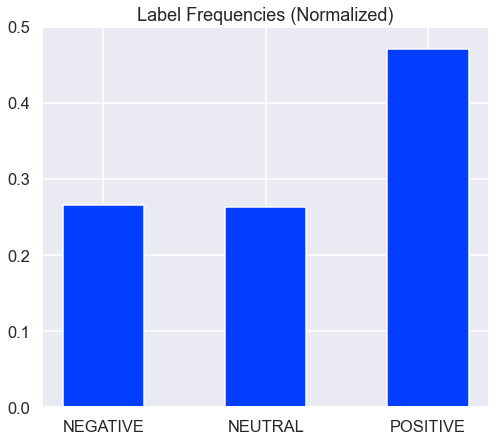

In [36]:
plot_label_frequencies(corpus, 
                          document_col="tokens",
                          label_col="label",
                          filepath="images/training-corpus-statistics/training-label-frequencies.png")

##### *C.1.3.2 - Average Length of Tokenized Document*

In [37]:
average_token_length(corpus, document_col="tokens")

4.43

> The average length of the normalized *Training Corpus* was $4.43\ \text{tokens}/\text{document}$, which implies a relatively small number of tokens, on average, made it through the text normalization process. Since there is only an average of $4$-$5$ tokens per normalized tweet, collecting $N$-grams larger than unigrams isn't likely to provide much additional benefit. For this reason, only unigrams were considered during the vectorization process (see *__Section C.3__*).

##### *C.1.3.3 - Document Frequencies by Label*

> The following three plots list the top $30$ most frequently occurring words for each sentiment label in the *Training Corpus*. Note that the ***document frequency*** of a certain word refers to the number of documents (i.e. tweets) in the corpus containing that word. 

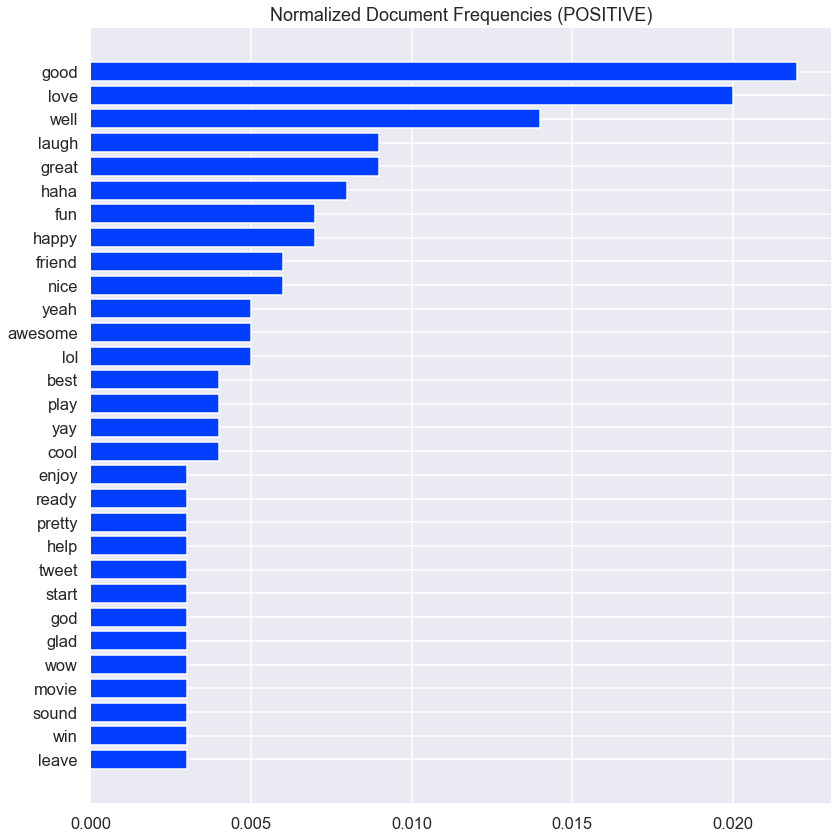

In [38]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="label",
                              label_name="POSITIVE", 
                              N=30, 
                              figsize=(12,12), 
                              filepath="images/training-corpus-statistics/POSITIVE-document-frequencies.png")

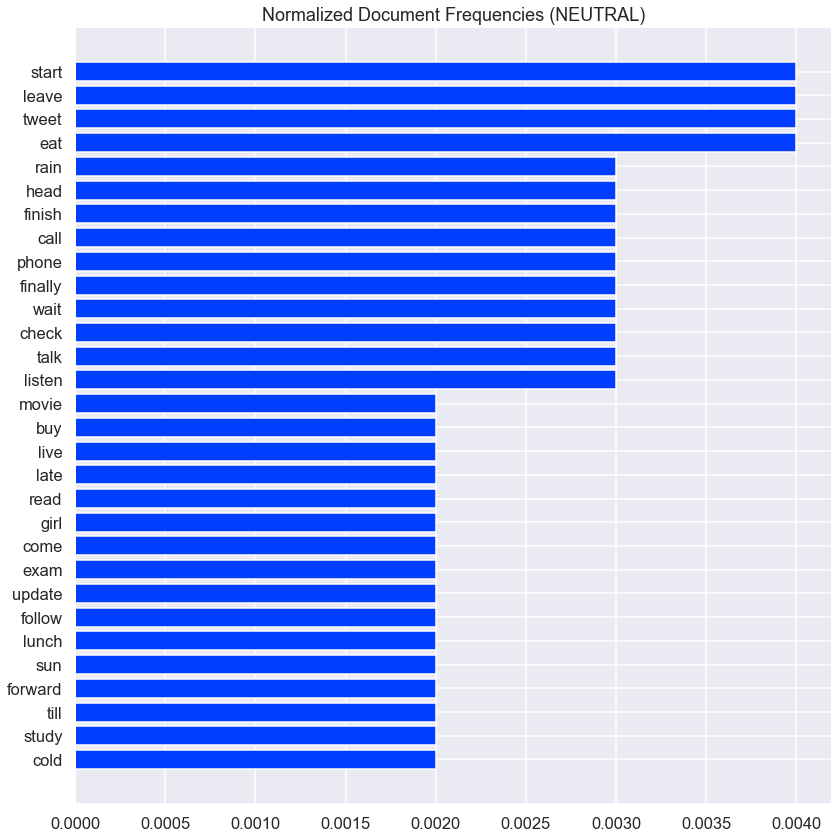

In [39]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="label",
                              label_name="NEUTRAL", 
                              N=30, 
                              figsize=(12,12), 
                              filepath="images/training-corpus-statistics/NEUTRAL-document-frequencies.png")

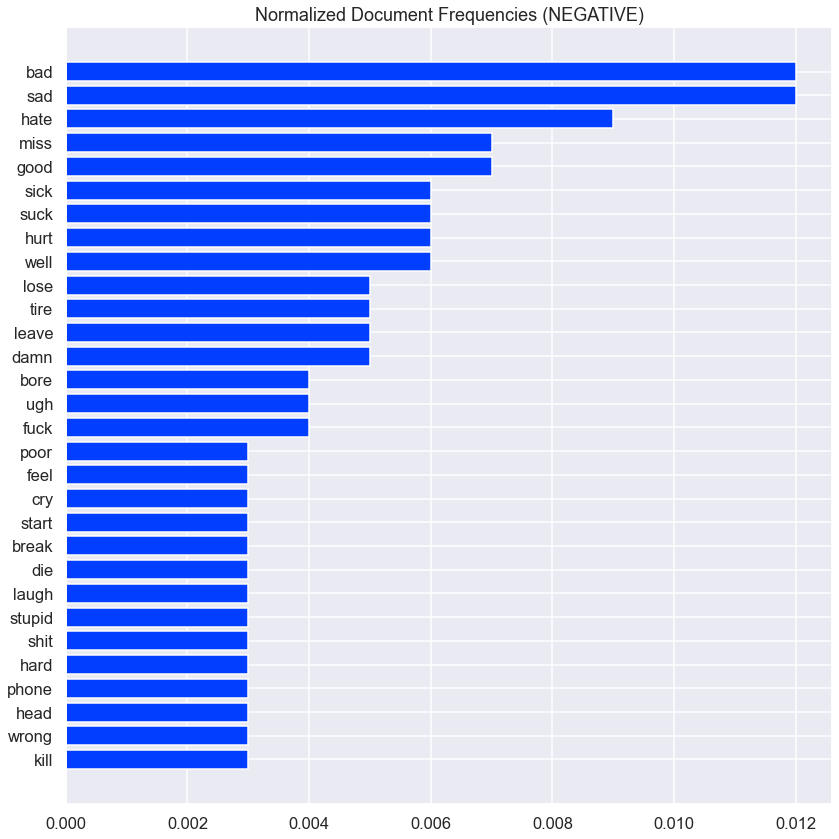

In [40]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="label",
                              label_name="NEGATIVE", 
                              N=30, 
                              figsize=(12,12), 
                              filepath="images/training-corpus-statistics/NEGATIVE-document-frequencies.png")

The plots above indicate that:

* words such as __`good`__, __`love`__, __`well`__, and __`laugh`__ are more prevalent in tweets with a __`POSITIVE`__ sentiment 
* words such as __`start`__, __`leave`__, __`eat`__, and __`rain`__ are more prevalent in tweets with a __`NEUTRAL`__ sentiment 
* words such as __`bad`__, __`sad`__, __`hate`__, and __`miss`__ are more prevalent in tweets with a __`NEGATIVE`__ sentiment 

> As these words would typically be associated with those sentiments, the plots confirm that the *Training Corpus* was indeed labeled accurately.

### *C.1.4 - Preprocessing the __Test Corpus__*

##### *C.1.4.1 - Parsing Location of each Tweet from Entry in `user_location` Column* 

> Users on Twitter are not required to disclose any type of location data in their profile, which essentially meant that the `user_location` column consisted of freeform text input. The `parse_state_from_location` function was created to solve this issue - it uses regular expressions to scan a piece of unstructured text for any mention of one of the $50$ American states. This function was applied to the `user_location` column of the *Training Corpus*.

In [41]:
def parse_state_from_location(corpus, *, location_col):
    states_dict = {}
    with open("data/us_states.csv") as file_iter:
        for row in file_iter.readlines():
            state_id, state_name = map(str.strip, row.split(','))
            states_dict.update({state_id: state_name})

    state_id_lookup = {state_name: state_id for state_id, state_name in states_dict.items()}

    cities_dict = {}
    with open("data/us_cities.csv") as file_iter:
        for row in file_iter.readlines():
            city_name, state_name = map(str.strip, row.split(','))
            if state_id_lookup[state_name] not in cities_dict:
                cities_dict[state_id_lookup[state_name]] = []
            cities_dict[state_id_lookup[state_name]].append(city_name)
        cities_dict["NY"].append("NYC")
        cities_dict["OK"].append("OKC")
        cities_dict["PA"].append("Philly")
            
    for state_id, state_name in states_dict.items():
        states_dict.update({state_id: rf"\b{state_id}\b|\b{state_name}\b"})
    
    for state_id, city_names in cities_dict.items():
        cities_dict.update({state_id: '|'.join(r"\b" + city + r"\b" for city in city_names)})
    
    locations = corpus[location_col]
    
    unparsed_index = corpus.index
    
    for state_id in states_dict:
        state_pattern = states_dict[state_id]
        scan_results = regex_scan(corpus, 
                                      col_name=location_col, 
                                      pattern=state_pattern,
                                      flags=re.IGNORECASE|re.ASCII,
                                      append_to_corpus=False)
        parsed_indices = scan_results.loc[scan_results == True].index

        corpus[location_col].iloc[parsed_indices] = state_id
        unparsed_index = unparsed_index.difference(parsed_indices)
        
    for state_id in cities_dict:
        city_pattern = cities_dict[state_id]
        scan_results = regex_scan(corpus, 
                                      col_name=location_col, 
                                      pattern=city_pattern,
                                      flags=re.IGNORECASE|re.ASCII,
                                      append_to_corpus=False)
        parsed_indices = scan_results.loc[scan_results == True].index
        corpus[location_col].iloc[parsed_indices] = state_id
        unparsed_index = unparsed_index.difference(parsed_indices)    
        
    corpus[location_col].loc[unparsed_index] = pd.NA

In [42]:
parse_state_from_location(test_corpus, location_col="user_location")

In [43]:
test_corpus.head()

,user_location,like_count,text,label
0,TX,0,A policy of systematic land confiscation by @AbiyAhmedAli &amp; his allies applied against Tigray. Over 12000Tigrayans civilians forced off thier land &amp; end up in Semera desert Concentration Camp.💔#TigrayGenocide https://t.co/5zmW2fOf5y @SecBlinken @CharlesMichel @SenSchumer @POTUS,NEGATIVE
1,<NA>,0,"(Bloomberg) -- President Joe Biden won dismissal of a lawsuit by former White House press secretary Sean Spicer over his firing from the board of the US Naval Academy, which advises the commander-in-chief. Story via @eelarson on @TheTerminal",POSITIVE
2,WA,0,"Democrats failure is complete? @POTUS has created 8m + jobs, reduced COVID deaths by 90%, passed the American Rescue Plan + bipartisan infrastructure, confirmed Judge Jackson + most judges since JFK. And we're close to getting a historic deal on Rx drugs. A ""failure"" this is not. https://t.co/htWVTVhLsO",POSITIVE
3,<NA>,0,"@ThePlumLineGS Manchin is foolish if he thinks this will gain favor with GOP voters, who will just vote GOP. Dems are foolish if they think green policies will gain favor with #Manchin, who profits from coal. #Biden is foolish if he thinks #ClimateAction can wait until this is all sorted out.",POSITIVE
4,<NA>,1,"@LuckyMcGee @POTUS To be fair, two years ago was on the glut of supply end of the pandemic. Cheering that you've made the price go down from record highs to what would still have been record highs a year ago is definitely 🤡🌍 stuff though.",POSITIVE


In [44]:
test_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96997 entries, 0 to 96996
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_location  29929 non-null  string
 1   like_count     96997 non-null  Int64 
 2   text           96997 non-null  string
 3   label          96997 non-null  string
dtypes: Int64(1), string(3)
memory usage: 3.1 MB


##### *C.1.4.4 - Computing the `sentiment_multiplier` for each Tweet from Entry in `like_count` Column* 

> It was assumed that the number of likes associated with a tweet is equivalent to the number of other Twitter users who agree with the sentiment of that tweet. Therefore, the `sentiment_multiplier` column was created to reflect this. 

For a tweet with $N_L$ likes, the sentiment multiplier ($N_S$) corresponds to the aggregate of the author's sentiment and the $N_L$ other users who agreed with that sentiment by liking the author's tweet. Mathematically, this is given by the following equation:
$$ N_S = N_L+1 $$

> **_It is important to note that values in the `sentiment_multiplier` column were only used when calculating the overall approval rating, that is, they were omitted when calculating approval ratings by state. The reason being that the locations of the users who liked a specific tweet were not known._**

In [45]:
test_corpus["sentiment_multiplier"] = test_corpus["like_count"] + 1 
test_corpus.drop(columns="like_count", inplace=True)

In [46]:
test_corpus = test_corpus.loc[:, ["user_location", "sentiment_multiplier", "text", "label"]]

In [47]:
test_corpus.head()

,user_location,sentiment_multiplier,text,label
0,TX,1,A policy of systematic land confiscation by @AbiyAhmedAli &amp; his allies applied against Tigray. Over 12000Tigrayans civilians forced off thier land &amp; end up in Semera desert Concentration Camp.💔#TigrayGenocide https://t.co/5zmW2fOf5y @SecBlinken @CharlesMichel @SenSchumer @POTUS,NEGATIVE
1,<NA>,1,"(Bloomberg) -- President Joe Biden won dismissal of a lawsuit by former White House press secretary Sean Spicer over his firing from the board of the US Naval Academy, which advises the commander-in-chief. Story via @eelarson on @TheTerminal",POSITIVE
2,WA,1,"Democrats failure is complete? @POTUS has created 8m + jobs, reduced COVID deaths by 90%, passed the American Rescue Plan + bipartisan infrastructure, confirmed Judge Jackson + most judges since JFK. And we're close to getting a historic deal on Rx drugs. A ""failure"" this is not. https://t.co/htWVTVhLsO",POSITIVE
3,<NA>,1,"@ThePlumLineGS Manchin is foolish if he thinks this will gain favor with GOP voters, who will just vote GOP. Dems are foolish if they think green policies will gain favor with #Manchin, who profits from coal. #Biden is foolish if he thinks #ClimateAction can wait until this is all sorted out.",POSITIVE
4,<NA>,2,"@LuckyMcGee @POTUS To be fair, two years ago was on the glut of supply end of the pandemic. Cheering that you've made the price go down from record highs to what would still have been record highs a year ago is definitely 🤡🌍 stuff though.",POSITIVE


### *C.1.5 - Normalizing the __Test Corpus__*

In [48]:
test_corpus = normalize_corpus(test_corpus, 
                                    document_col="text",
                                    label_col=None,
                                    remove_corpus_stopwords=False)

Stripping accents ...... COMPLETE
Stripping newline characters ...... COMPLETE
Stripping Twitter handles ...... COMPLETE
Stripping Twitter hashtags ...... COMPLETE
Stripping Twitter technical abbreviations ...... COMPLETE
Stripping web addresses ...... COMPLETE
Stripping HTML entities ...... COMPLETE
Expanding contractions ...... COMPLETE
Stripping non-alphabetical characters ...... COMPLETE
Expanding abbreviations ...... COMPLETE
Tokenizing ...... COMPLETE
Removing single character tokens ...... COMPLETE
Removing stopwords ...... COMPLETE
Removing common names ...... COMPLETE
Lemmatizing ...... COMPLETE
Removing empty token lists ...... COMPLETE


In [49]:
test_corpus.head()

,user_location,sentiment_multiplier,tokens,label
0,TX,1,"[policy, systematic, land, confiscation, ally, apply, tigray, tigrayans, civilian, force, thier, land, semera, desert, concentration, camp]",NEGATIVE
1,<NA>,1,"[bloomberg, president, biden, win, dismissal, lawsuit, white, house, press, secretary, spicer, fire, board, naval, academy, advise, commander, chief, story]",POSITIVE
2,WA,1,"[democrat, failure, complete, create, job, reduce, covid, death, pass, american, rescue, plan, bipartisan, infrastructure, confirm, judge, judge, jfk, close, historic, deal, rx, drug, failure]",POSITIVE
3,<NA>,1,"[manchin, foolish, think, gain, favor, gop, voter, vote, gop, dems, foolish, green, policy, gain, favor, profit, coal, foolish, think, wait, sort]",POSITIVE
4,<NA>,2,"[fair, year, ago, glut, supply, pandemic, cheering, price, record, highs, record, high, year, ago, definitely, stuff]",POSITIVE


## C.2 - Extracting the Trainining, Validation, and Test Sets

> The *Test Corpus* was randomly split into the Training Set and Validation Set, with these datasets containing $80\%$ and $20\%$ of the training documents respectively. The Test Set was created from the documents in the *Test Corpus*.

### *C.2.1 - Extracting the Training and Validation Sets from the __Training Corpus__*

In [50]:
if isinstance(corpus["tokens"][0], list):
    corpus["tokens"] = corpus["tokens"].apply(' '.join)

In [51]:
X = corpus["tokens"]
y = corpus["label"]

In [52]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [53]:
print(f"X_train:\t({' x '.join(map(str, X_train.shape))})")
print(f"y_train:\t({' x '.join(map(str, y_train.shape))})\n")
print(f"X_validate:\t({' x '.join(map(str, X_validate.shape))})")
print(f"y_validate:\t({' x '.join(map(str, y_validate.shape))})")

X_train:	(1231502)
y_train:	(1231502)

X_validate:	(307876)
y_validate:	(307876)


### *C.2.2 - Extracting the Test Set from the __Test Corpus__*

In [54]:
if isinstance(test_corpus["tokens"][0], list):
    test_corpus["tokens"] = test_corpus["tokens"].apply(' '.join)

In [55]:
X_test = test_corpus["tokens"]
y_test = test_corpus["label"]

In [56]:
print(f"X_test:\t({' x '.join(map(str, X_test.shape))})")
print(f"y_test:\t({' x '.join(map(str, y_test.shape))})")

X_test:	(92662)
y_test:	(92662)


## C.3 - Vectorizing the Training, Validation, and Test Sets

> The number of features used during the vectorization process was $15,000$. Only unigrams were considered. The Training, Validation, and Test Set were vectorized via the `sklearn.CountVectorizer` transformer and `tensorflow.keras.layers.TextVectorization` layer.  

In [57]:
MAX_FEATURES = 15_000
MAX_DOCUMENT_LENGTH = max(len(token_list) for token_list in corpus.tokens.str.split())

### *C.3.1 - Count Vectorization (for use in __Naive Bayes__, __Randomized Forest__, and __Logistic Regression__ Models)*

> The `sklearn.CountVectorizer` transformer was fitted to the Training Set and then used to transform the Training, Validation, and Test Set into a matrix of token counts (i.e. Bag of Words).

In [58]:
count_vectorizer = CountVectorizer(max_features=MAX_FEATURES)

In [59]:
X_train_CV = count_vectorizer.fit_transform(X_train)
X_train_CV = pd.DataFrame.sparse.from_spmatrix(X_train_CV)
X_train_CV.columns = sorted(count_vectorizer.vocabulary_)
X_train_CV.set_index(y_train.index, inplace=True)

In [60]:
X_train_CV.head()

,aaaah,aaaahhh,aaaand,aaaargh,aaages,aaah,aaahh,aaahhh,aaall,aaalll,...,zomg,zone,zoo,zooey,zoom,zucchini,zumba,zune,zurich,zyrtec
1297791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1414798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
958016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1163713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
X_validate_CV = count_vectorizer.transform(X_validate)
X_validate_CV = pd.DataFrame.sparse.from_spmatrix(X_validate_CV)
X_validate_CV.columns = sorted(count_vectorizer.vocabulary_)
X_validate_CV.set_index(y_validate.index, inplace=True)

In [62]:
X_validate_CV.head()

,aaaah,aaaahhh,aaaand,aaaargh,aaages,aaah,aaahh,aaahhh,aaall,aaalll,...,zomg,zone,zoo,zooey,zoom,zucchini,zumba,zune,zurich,zyrtec
771247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
659646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
410170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X_test_CV = count_vectorizer.transform(X_test)
X_test_CV = pd.DataFrame.sparse.from_spmatrix(X_test_CV)
X_test_CV.columns = sorted(count_vectorizer.vocabulary_)

In [64]:
X_test_CV.head()

,aaaah,aaaahhh,aaaand,aaaargh,aaages,aaah,aaahh,aaahhh,aaall,aaalll,...,zomg,zone,zoo,zooey,zoom,zucchini,zumba,zune,zurich,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### *C.3.2 - Integer Encoding (for use in __Recurrant Neural Networks__)*

> The `tensorflow.keras.layers.TextVectorization` layer was adapted to the Training Set and then used to transform the Training, Validation, and Test Set into a collection of $1$-dimensional tensors comprised of integer indexed tokens.

In [65]:
integer_encoder = TextVectorization(max_tokens=MAX_FEATURES,
                                        standardize=None,
                                        split="whitespace",
                                        ngrams=None,
                                        output_mode="int",
                                        output_sequence_length=MAX_DOCUMENT_LENGTH,
                                        pad_to_max_tokens=False)

In [66]:
integer_encoder.adapt(X_train.values)

In [67]:
X_train_IE = integer_encoder(X_train.values)
X_train_IE

<tf.Tensor: shape=(1231502, 33), dtype=int64, numpy=
array([[  455,  3990,     0, ...,     0,     0,     0],
       [ 1067,   530,   185, ...,     0,     0,     0],
       [  423,     0,     0, ...,     0,     0,     0],
       ...,
       [  444,   838,     0, ...,     0,     0,     0],
       [11495,     1,   511, ...,     0,     0,     0],
       [ 1031,   171,   102, ...,     0,     0,     0]], dtype=int64)>

In [68]:
X_validate_IE = integer_encoder(X_validate.values)
X_validate_IE

<tf.Tensor: shape=(307876, 33), dtype=int64, numpy=
array([[ 129,  122,  125, ...,    0,    0,    0],
       [ 407, 1684,  432, ...,    0,    0,    0],
       [   1,  356,  308, ...,    0,    0,    0],
       ...,
       [ 594,   83,    1, ...,    0,    0,    0],
       [ 276, 6395, 8371, ...,    0,    0,    0],
       [2676, 1184,    0, ...,    0,    0,    0]], dtype=int64)>

In [69]:
X_test_IE = integer_encoder(X_test.values)
X_test_IE

<tf.Tensor: shape=(92662, 33), dtype=int64, numpy=
array([[ 4040,     1,   722, ...,     0,     0,     0],
       [    1,  3055,     1, ...,     0,     0,     0],
       [14677,  2164,   685, ...,     0,     0,     0],
       ...,
       [ 3128,     1,   836, ...,     0,     0,     0],
       [  663,   638,     0, ...,     0,     0,     0],
       [    1, 14614, 12242, ...,     0,     0,     0]], dtype=int64)>

## C.4 - Encoding the Training, Validation, and Test Labels

### *C.4.1 - Integer Encoding (for use in __Naive Bayes__, __Randomized Forest__, and __Logistic Regression__ Models)*

In [70]:
le = LabelEncoder()

In [71]:
y_train_LE = le.fit_transform(y_train.to_numpy())
y_train_LE

array([1, 0, 1, ..., 2, 1, 0])

In [72]:
y_validate_LE = le.transform(y_validate.to_numpy())
y_validate_LE

array([0, 2, 1, ..., 0, 1, 2])

In [73]:
y_test_LE = le.transform(y_test.to_numpy())
y_test_LE

array([0, 2, 2, ..., 2, 2, 0])

In [74]:
print(f"y_train_LE:\t({' x '.join(map(str, y_train_LE.shape))})")
print(f"y_validate_LE:\t({' x '.join(map(str, y_validate_LE.shape))})")
print(f"y_test_LE:\t({' x '.join(map(str, y_test_LE.shape))})")

y_train_LE:	(1231502)
y_validate_LE:	(307876)
y_test_LE:	(92662)


### *C.4.2 - One-Hot Encoding (for use in __Recurrent Neural Networks__)*

In [75]:
lb = LabelBinarizer() 

In [76]:
y_train_OHE = lb.fit_transform(y_train)
y_train_OHE

array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

In [77]:
y_validate_OHE = lb.transform(y_validate)
y_validate_OHE

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [78]:
y_test_OHE = lb.transform(y_test)
y_test_OHE

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

In [79]:
print(f"y_train_OHE:\t({' x '.join(map(str, y_train_OHE.shape))})")
print(f"y_validate_OHE:\t({' x '.join(map(str, y_validate_OHE.shape))})")
print(f"y_test_OHE:\t({' x '.join(map(str, y_validate_OHE.shape))})")

y_train_OHE:	(1231502 x 3)
y_validate_OHE:	(307876 x 3)
y_test_OHE:	(307876 x 3)


## C.5 - Balancing the Training Data

In [80]:
sample_weights = compute_sample_weight("balanced", y_train_LE)
sample_weights

array([1.26573897, 1.25579536, 1.26573897, ..., 0.70739388, 1.26573897,
       1.25579536])

# D. *Modeling*

Since over-representing sentiment (high false positive rate) and under-representing sentiment (high false negative rate) are both equally undesirable, the $F_1\text{-Score}$ was the primary metric by which models were evaluated. This score takes into account both recall ($R$) and precision ($P$) - if one of these metrics suffers, it will be reflected in the $F_1\text{-Score}$. The formula for the $F_1\text{-Score}$ is:
> $$ F_1 = 2(\dfrac{1}{R} + \dfrac{1}{P}) $$



## D.1 - Naive Bayes

In [81]:
mnb = MultinomialNB(alpha=0.01)

In [82]:
mnb.fit(X_train_CV, y_train_LE, sample_weight=sample_weights)
y_train_mnb_pred = mnb.predict(X_train_CV)
y_validate_mnb_pred = mnb.predict(X_validate_CV)

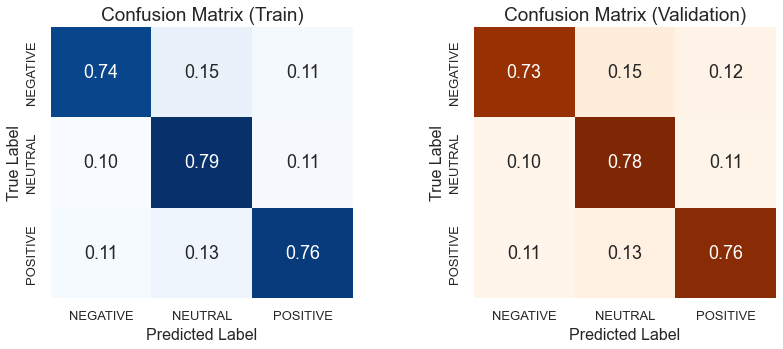

In [83]:
plot_confusion_matrices(y_train_LE, 
                            y_train_mnb_pred, 
                            y_validate_LE, 
                            y_validate_mnb_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/mnb/validation-confusion-matrices.png")

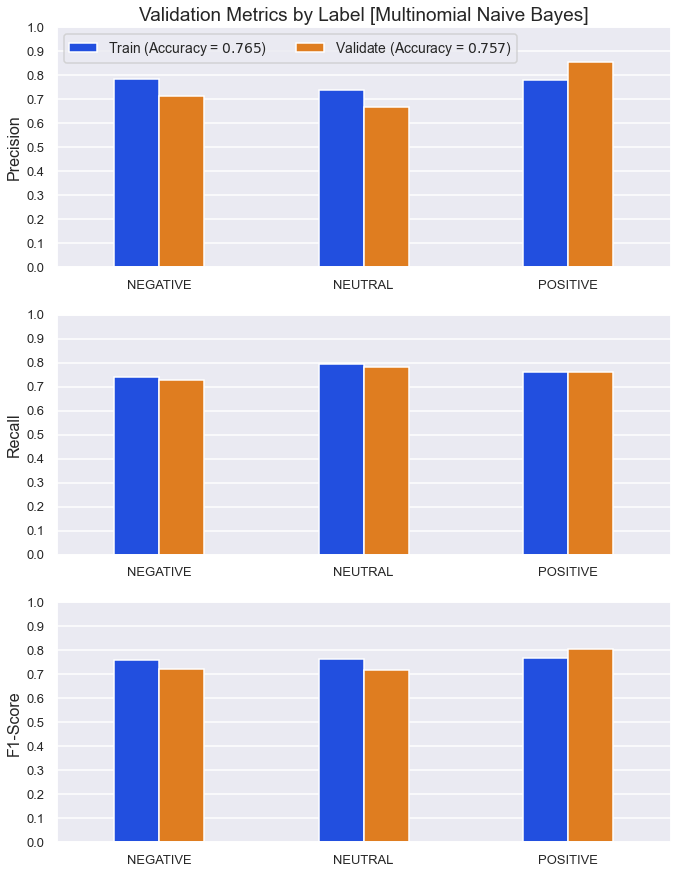

In [84]:
plot_validation_metrics_by_label(y_train_LE, 
                                     y_train_mnb_pred, 
                                     y_validate_LE, 
                                     y_validate_mnb_pred, 
                                     score_names=["precision", "recall", "f1-score"], 
                                     target_names=le.classes_, 
                                     estimator_label="Multinomial Naive Bayes", 
                                     sample_weight=sample_weights,
                                     filepath="images/mnb/validation-metrics-by-label.png")

In [85]:
mnb_val_metrics = get_classification_metrics(y_validate_LE, 
                                               y_validate_mnb_pred, 
                                               target_names=le.classes_)
mnb_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.713,0.665,0.855,0.744
Recall,0.729,0.782,0.760,0.757
F1-Score,0.721,0.719,0.804,0.748
Accuracy,NaN,NaN,NaN,0.757


## D.2 - Random Forest

In [86]:
rfc = RandomForestClassifier(random_state=0, 
                                 class_weight="balanced", 
                                 n_jobs=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 69.4min remaining: 69.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 137.4min finished


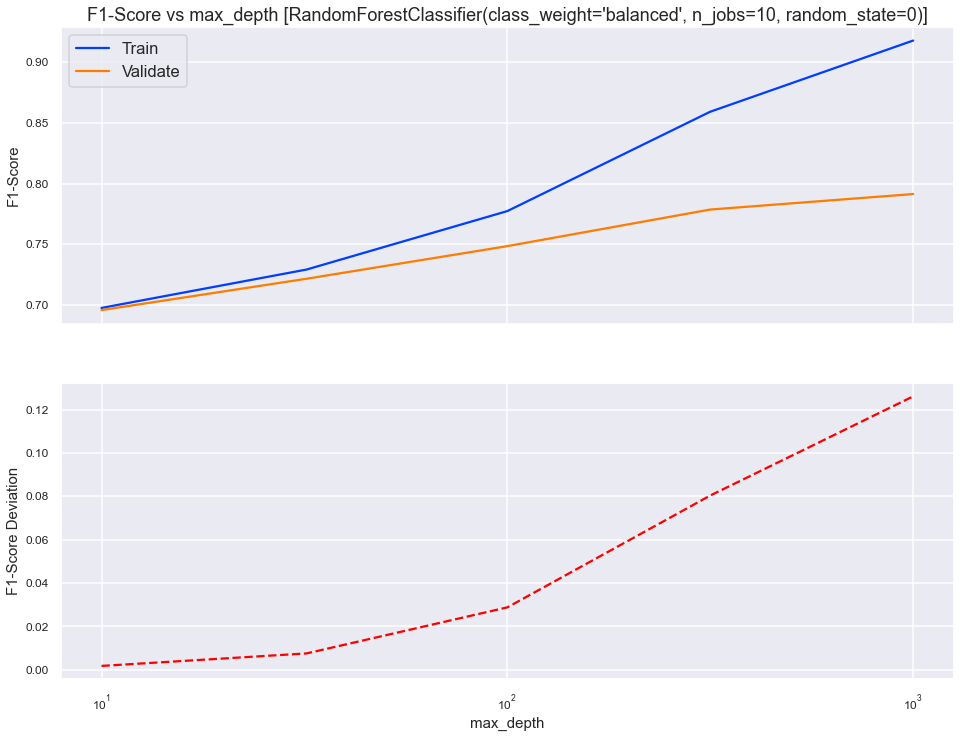

In [87]:
max_depth_params = np.logspace(1, 3, 5).round()

plot_validation_curve(rfc, 
                        X_train_CV, 
                        y_train_LE, 
                        param_name="max_depth", 
                        param_range=max_depth_params, 
                        scoring="f1_weighted", 
                        scoring_label="F1-Score",
                        cv=2,
                        semilogx=True,
                        filepath="images/rfc/max-depth-validation-curve.png")

In [88]:
rfc.max_depth = 100

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 80.6min remaining: 80.6min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 83.8min finished


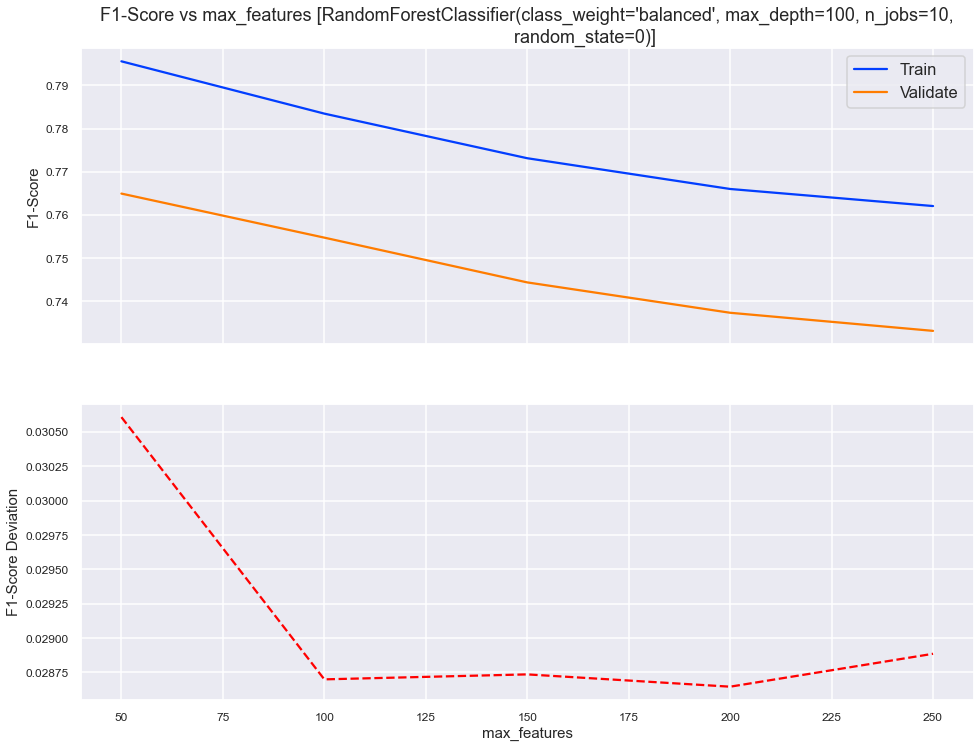

In [89]:
max_features_params = np.linspace(50, 250, 5).astype(int)

plot_validation_curve(rfc, 
                        X_train_CV, 
                        y_train_LE, 
                        param_name="max_features", 
                        param_range=max_features_params, 
                        scoring="f1_weighted", 
                        scoring_label="F1-Score",
                        cv=2,
                        n_jobs=10,
                        filepath="images/rfc/max-features-validation-curve.png")

In [90]:
rfc.max_features = 50

In [91]:
rfc.fit(X_train_CV, y_train_LE)

y_train_rfc_pred = rfc.predict(X_train_CV)
y_validate_rfc_pred = rfc.predict(X_validate_CV)

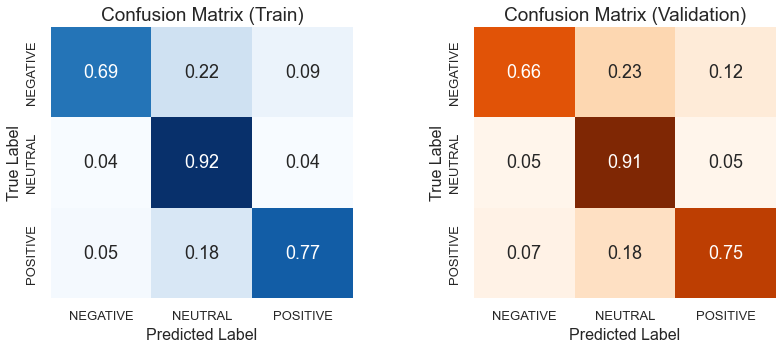

In [92]:
plot_confusion_matrices(y_train_LE, 
                            y_train_rfc_pred, 
                            y_validate_LE, 
                            y_validate_rfc_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/rfc/validation-confusion-matrices.png")

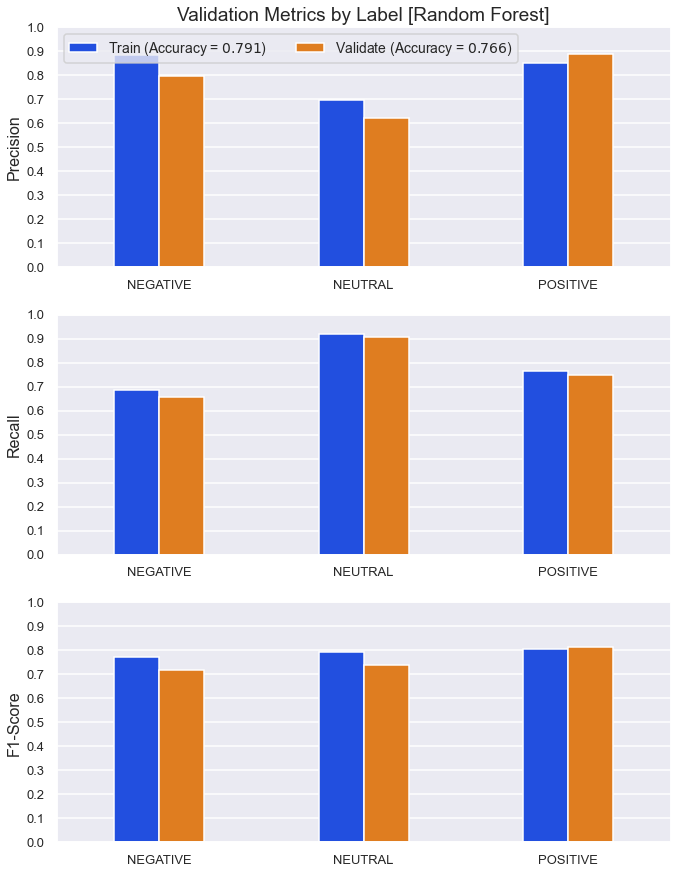

In [93]:
plot_validation_metrics_by_label(y_train_LE, 
                                     y_train_rfc_pred, 
                                     y_validate_LE, 
                                     y_validate_rfc_pred, 
                                     score_names=["precision", "recall", "f1-score"], 
                                     target_names=le.classes_, 
                                     estimator_label="Random Forest", 
                                     sample_weight=sample_weights,
                                     filepath="images/rfc/validation-metrics-by-label.png")

In [94]:
rfc_val_metrics = get_classification_metrics(y_validate_LE, 
                                              y_validate_rfc_pred, 
                                              target_names=le.classes_)
rfc_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.795,0.622,0.889,0.769
Recall,0.656,0.906,0.750,0.770
F1-Score,0.719,0.737,0.814,0.757
Accuracy,NaN,NaN,NaN,0.766


## D.3 - Logistic Regression

In [95]:
logreg = LogisticRegression(solver='saga', 
                               random_state=0, 
                               max_iter=10_000, 
                               class_weight="balanced", 
                               multi_class="multinomial", 
                               n_jobs=10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed: 66.3min remaining: 66.3min
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed: 112.0min finished


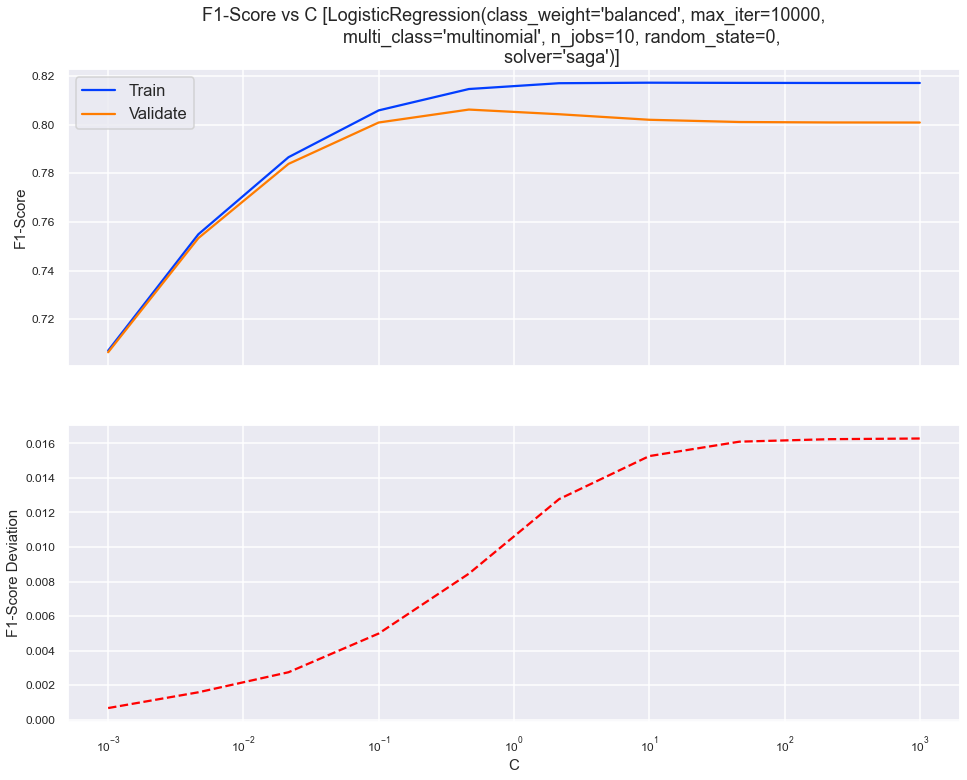

In [96]:
C_params = np.logspace(-3, 3, 10)

plot_validation_curve(logreg, 
                        X_train_CV, 
                        y_train_LE, 
                        param_name="C", 
                        param_range=C_params, 
                        scoring="f1_weighted", 
                        scoring_label="F1-Score",
                        cv=2,
                        n_jobs=10,
                        semilogx=True,
                        filepath="images/logreg/validation-curve.png")

In [97]:
logreg.C = 0.316

In [98]:
logreg.fit(X_train_CV, y_train_LE)

y_train_logreg_pred = logreg.predict(X_train_CV)
y_validate_logreg_pred = logreg.predict(X_validate_CV)

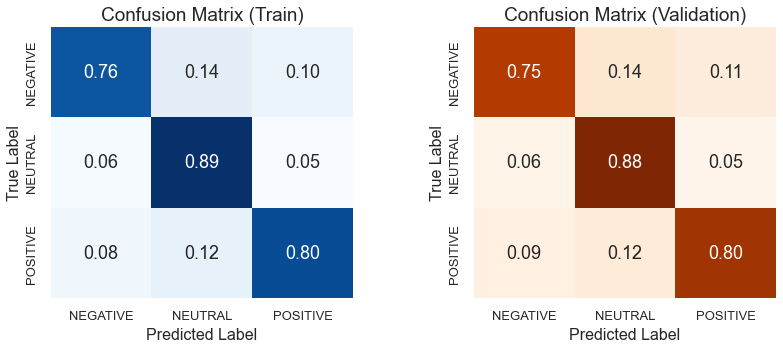

In [99]:
plot_confusion_matrices(y_train_LE, 
                            y_train_logreg_pred, 
                            y_validate_LE, 
                            y_validate_logreg_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/logreg/validation-confusion-matrices.png")

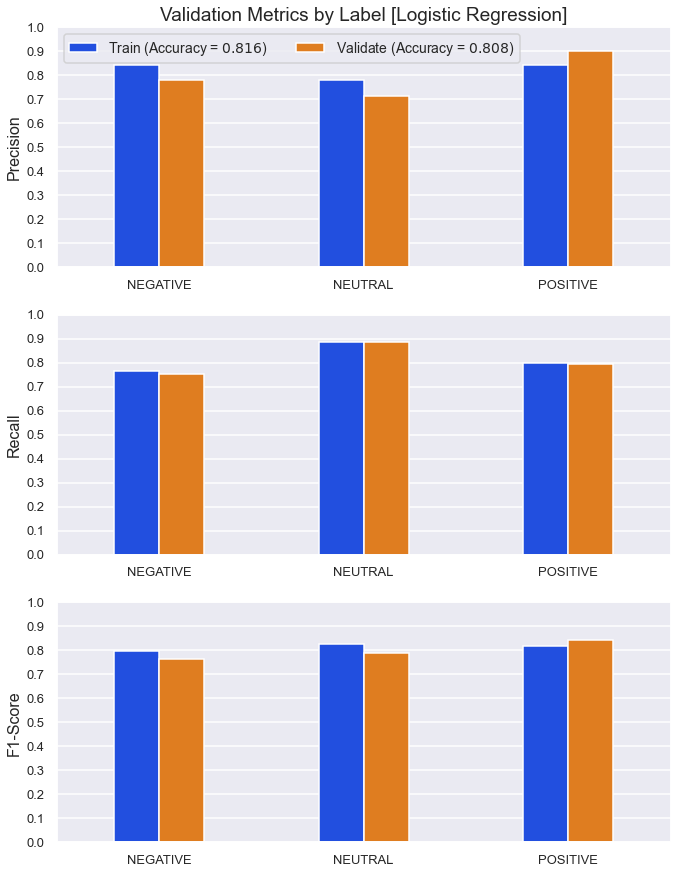

In [100]:
plot_validation_metrics_by_label(y_train_LE, 
                                     y_train_logreg_pred, 
                                     y_validate_LE, 
                                     y_validate_logreg_pred, 
                                     score_names=["precision", "recall", "f1-score"], 
                                     target_names=le.classes_, 
                                     estimator_label="Logistic Regression", 
                                     sample_weight=sample_weights,
                                     filepath="images/logreg/validation-metrics-by-label.png")

In [101]:
logreg_val_metrics = get_classification_metrics(y_validate_LE, 
                                                      y_validate_logreg_pred, 
                                                      target_names=le.classes_)
logreg_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.778,0.713,0.900,0.797
Recall,0.754,0.884,0.795,0.811
F1-Score,0.766,0.790,0.844,0.800
Accuracy,NaN,NaN,NaN,0.808


## D.4 - Recurrent Neural Network (RNN)

### *D.4.1 - Loading Pre-Trained Word Embeddings*

> Pre-trained word embeddings will be loaded from the `data/glove.twitter.27B.100d.txt` file. The imported word embeddings will be converted into an embedding matrix which, in turn, will be passed into a `tensorflow.keras.layers.Embedding` object to create a non-trainable embedding layer. The dimension of each word embedding in the `data/glove.twitter.27B.100d.txt` file is $100$, therefore the shape of the resulting embedding matrix will be $\{15,000 \times 100\}$.

In [102]:
vocabulary = integer_encoder.get_vocabulary(include_special_tokens=True)
word_index = dict(zip(vocabulary, range(len(vocabulary))))

In [103]:
embeddings_index = {}
with open("data/glove.twitter.27B.100d.txt") as file_iter:
    for line in file_iter:
        word, coefficients = line.split(maxsplit=1)
        embeddings_index[word] = np.fromstring(coefficients, sep=' ')

In [104]:
NUM_TOKENS = len(vocabulary)
EMBEDDING_DIM = 100

successful_embeddings = 0
missed_embeddings = 0

embedding_matrix = np.zeros((NUM_TOKENS, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        successful_embeddings += 1
    else:
        missed_embeddings += 1    

print(f"Successful Embeddings:\t{successful_embeddings} [{(successful_embeddings / NUM_TOKENS) * 100:.2f}%]")
print(f"Missed Embeddings:\t{missed_embeddings} [{(missed_embeddings / NUM_TOKENS) * 100:.2f}%]")

Successful Embeddings:	14650 [97.67%]
Missed Embeddings:	350 [2.33%]


In [105]:
embedding_layer = Embedding(input_dim=NUM_TOKENS,
                                 output_dim=EMBEDDING_DIM,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 trainable=False)                               

### *D.4.2 - Building and Evaluating Various Architectures*

> A series of $5$ Recurrent Neural Networks (`RNN 1`, `RNN 2`, `RNN 3`, `RNN 4`, and `RNN 5`), containing one or more bidirectional LSTM layers, were trained on the Training Set. These models were validated against the Validation Set after every training epoch. After each of the $5$ training processes had been completed, the epoch in which the lowest cross-entropy loss on the Validation Set ocurred was determined and the model parameters chosen accordingly.

>For each successive RNN after *RNN 1*, the number of neurons per LSTM layer and/or the number of bidirectional LSTM layers was increased until overfitting started to negate improvements in the validation $F_1\text{-Score}$. At this point, the RNN showing the highest $F_1\text{-Score}$ on the Validation Set was chosen and compared against the `Naive Bayes`, `Random Forest`, and `Logistic Regression` models.

In [106]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

##### *`RNN 1`*

Epoch 1/50
2406/2406 [==============================] - 69s 28ms/step - loss: 0.7002 - accuracy: 0.7238 - val_loss: 0.6453 - val_accuracy: 0.7544
Epoch 2/50
2406/2406 [==============================] - 59s 24ms/step - loss: 0.6354 - accuracy: 0.7623 - val_loss: 0.6269 - val_accuracy: 0.7666
Epoch 3/50
2406/2406 [==============================] - 64s 27ms/step - loss: 0.6224 - accuracy: 0.7701 - val_loss: 0.6154 - val_accuracy: 0.7728
Epoch 4/50
2406/2406 [==============================] - 62s 26ms/step - loss: 0.6153 - accuracy: 0.7747 - val_loss: 0.6102 - val_accuracy: 0.7773
Epoch 5/50
2406/2406 [==============================] - 61s 25ms/step - loss: 0.6108 - accuracy: 0.7776 - val_loss: 0.6133 - val_accuracy: 0.7754
Epoch 6/50
2406/2406 [==============================] - 60s 25ms/step - loss: 0.6074 - accuracy: 0.7794 - val_loss: 0.5998 - val_accuracy: 0.7829
Epoch 7/50
2406/2406 [==============================] - 60s 25ms/step - loss: 0.6048 - accuracy: 0.7811 - val_loss: 0.6083 -

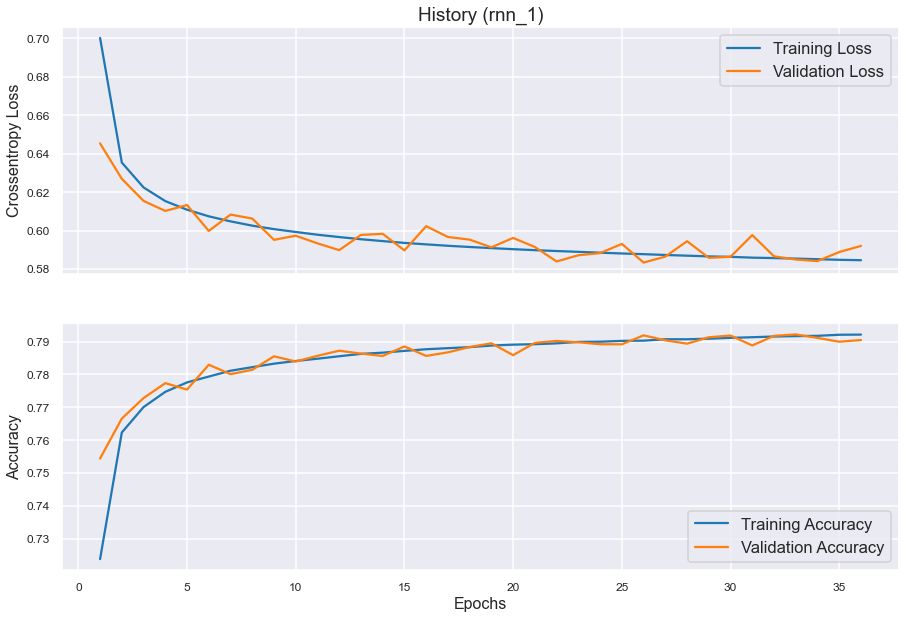

In [107]:
rnn_1 = Sequential(name="rnn_1")

rnn_1.add(embedding_layer)
rnn_1.add(Bidirectional(LSTM(4)))
rnn_1.add(Dense(3, activation='softmax'))

rnn_1.compile(optimizer="Adam",
                loss='categorical_crossentropy',
                metrics=['accuracy']) 


checkpoint = ModelCheckpoint(filepath="models/rnn1.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")

history_1 = rnn_1.fit(X_train_IE,
                         y_train_OHE,
                         batch_size=512,
                         epochs=50,
                         validation_data=(X_validate_IE, y_validate_OHE),
                         sample_weight=sample_weights,
                         callbacks=[early_stopping, checkpoint])

plot_history(rnn_1.name, 
              history_1.history, 
              filepath="images/rnn1/history.png")

In [109]:
rnn_1 = load_model("models/rnn1.h5")

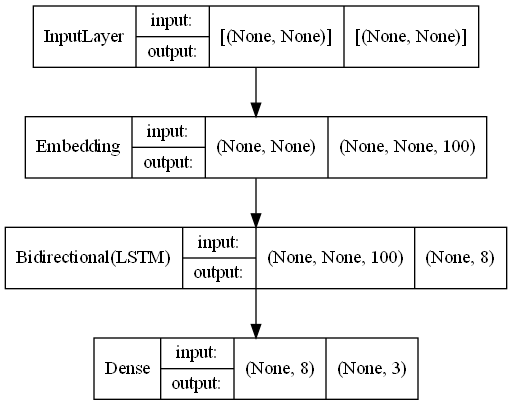

In [110]:
plot_model(rnn_1,
             to_file="images/rnn1/plot.png",
             show_shapes=True,
             show_layer_names=False)

In [111]:
y_train_rnn1_pred = rnn_1.predict(X_train_IE)
y_validate_rnn1_pred = rnn_1.predict(X_validate_IE)

y_train_rnn1_pred = le.transform(lb.inverse_transform(y_train_rnn1_pred))
y_validate_rnn1_pred = le.transform(lb.inverse_transform(y_validate_rnn1_pred))

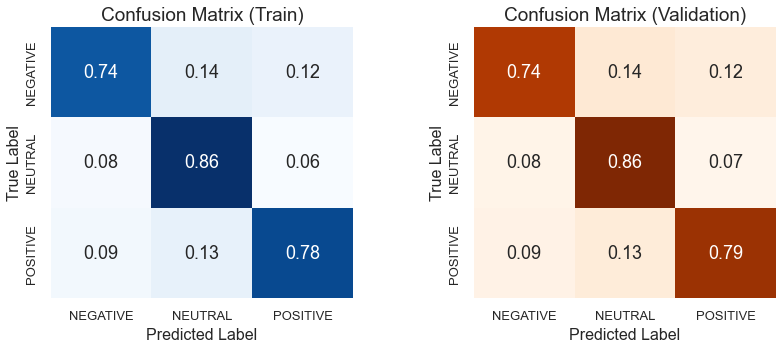

In [112]:
plot_confusion_matrices(y_train_LE, 
                            y_train_rnn1_pred, 
                            y_validate_LE, 
                            y_validate_rnn1_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/rnn1/validation-confusion-matrices.png")

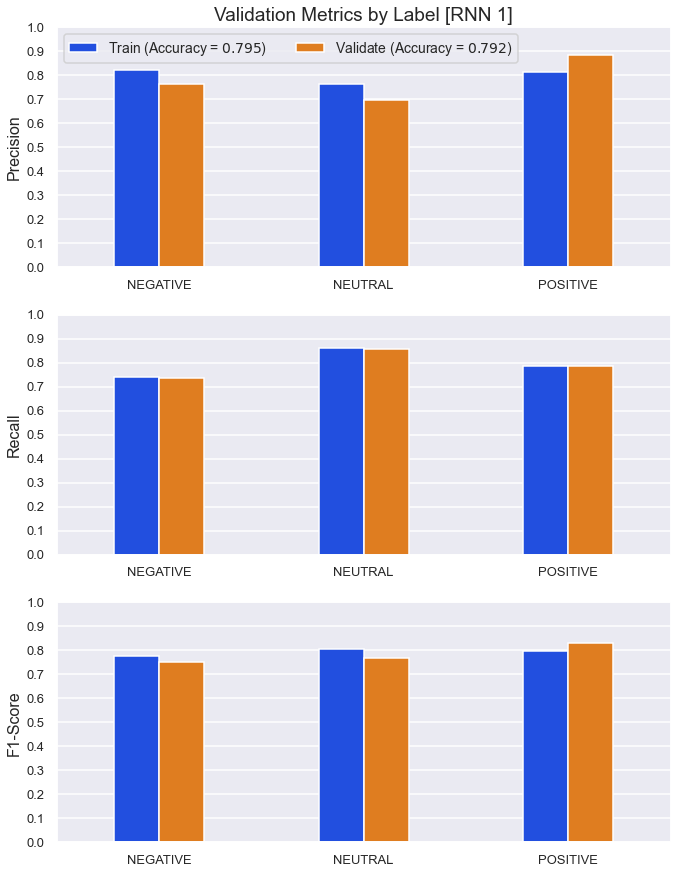

In [113]:
plot_validation_metrics_by_label(y_train_LE, 
                           y_train_rnn1_pred, 
                           y_validate_LE, 
                           y_validate_rnn1_pred, 
                           score_names=["precision", "recall", "f1-score"], 
                           target_names=le.classes_, 
                           estimator_label="RNN 1", 
                           sample_weight=sample_weights,
                           filepath="images/rnn1/validation-metrics-by-label.png")

In [114]:
rnn1_val_metrics = get_classification_metrics(y_validate_LE, 
                                                    y_validate_rnn1_pred, 
                                                    target_names=le.classes_)
rnn1_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.764,0.695,0.884,0.781
Recall,0.738,0.857,0.786,0.794
F1-Score,0.751,0.768,0.832,0.783
Accuracy,NaN,NaN,NaN,0.792


##### *`RNN 2`*

Epoch 1/50
2406/2406 [==============================] - 69s 28ms/step - loss: 0.6750 - accuracy: 0.7407 - val_loss: 0.6284 - val_accuracy: 0.7657
Epoch 2/50
2406/2406 [==============================] - 68s 28ms/step - loss: 0.6166 - accuracy: 0.7758 - val_loss: 0.6038 - val_accuracy: 0.7815
Epoch 3/50
2406/2406 [==============================] - 68s 28ms/step - loss: 0.6033 - accuracy: 0.7835 - val_loss: 0.5981 - val_accuracy: 0.7853
Epoch 4/50
2406/2406 [==============================] - 68s 28ms/step - loss: 0.5957 - accuracy: 0.7875 - val_loss: 0.5967 - val_accuracy: 0.7864
Epoch 5/50
2406/2406 [==============================] - 69s 28ms/step - loss: 0.5907 - accuracy: 0.7905 - val_loss: 0.5892 - val_accuracy: 0.7899
Epoch 6/50
2406/2406 [==============================] - 69s 29ms/step - loss: 0.5870 - accuracy: 0.7928 - val_loss: 0.5849 - val_accuracy: 0.7926
Epoch 7/50
2406/2406 [==============================] - 70s 29ms/step - loss: 0.5840 - accuracy: 0.7945 - val_loss: 0.5823 -

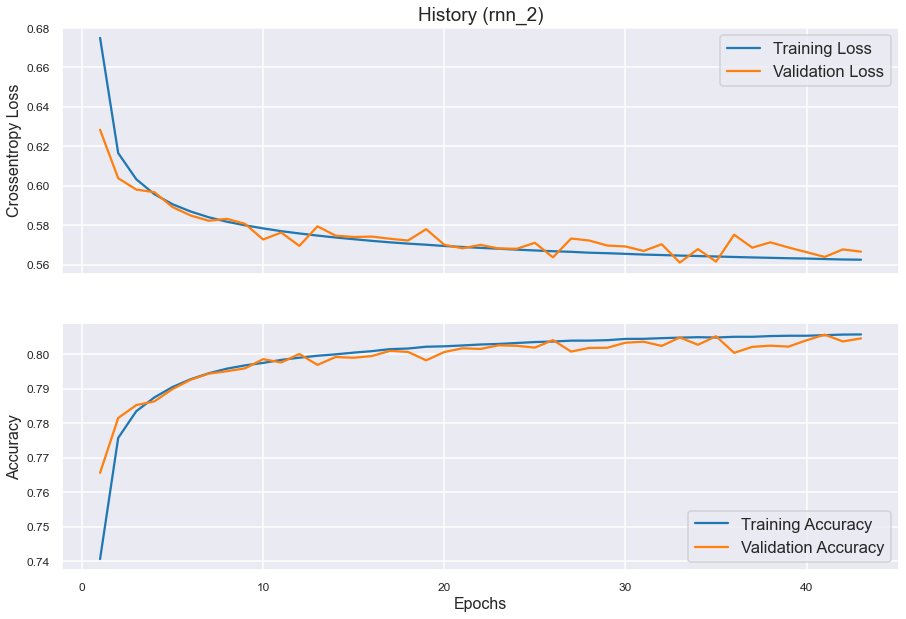

In [115]:
rnn_2 = Sequential(name="rnn_2")

rnn_2.add(embedding_layer)
rnn_2.add(Bidirectional(LSTM(8)))
rnn_2.add(Dense(3, activation='softmax'))

rnn_2.compile(optimizer="Adam",
                loss='categorical_crossentropy',
                metrics=['accuracy']) 


checkpoint = ModelCheckpoint(filepath="models/rnn2.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")

history_2 = rnn_2.fit(X_train_IE,
                         y_train_OHE,
                         batch_size=512,
                         epochs=50,
                         validation_data=(X_validate_IE, y_validate_OHE),
                         validation_batch_size=128,
                         sample_weight=sample_weights,
                         callbacks=[early_stopping, checkpoint])

plot_history(rnn_2.name, 
              history_2.history, 
              filepath="images/rnn2/history.png")

In [116]:
rnn_2 = load_model("models/rnn2.h5")

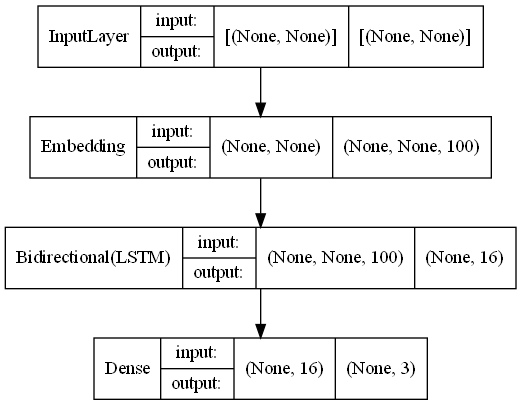

In [117]:
plot_model(rnn_2,
             to_file="images/rnn2/plot.png",
             show_shapes=True,
             show_layer_names=False)

In [118]:
y_train_rnn2_pred = rnn_2.predict(X_train_IE)
y_validate_rnn2_pred = rnn_2.predict(X_validate_IE)

y_train_rnn2_pred = le.transform(lb.inverse_transform(y_train_rnn2_pred))
y_validate_rnn2_pred = le.transform(lb.inverse_transform(y_validate_rnn2_pred))

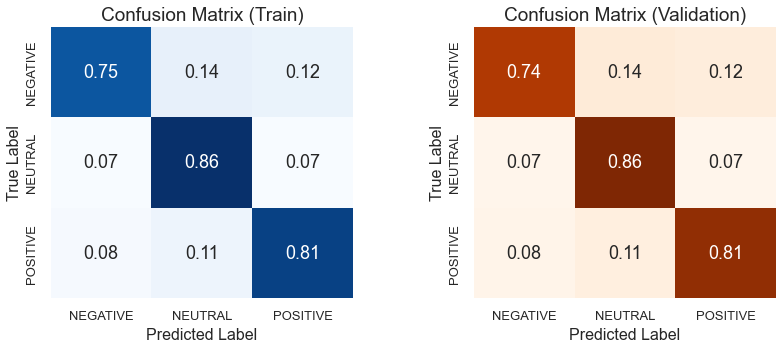

In [119]:
plot_confusion_matrices(y_train_LE, 
                            y_train_rnn2_pred, 
                            y_validate_LE, 
                            y_validate_rnn2_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/rnn2/validation-confusion-matrices.png")

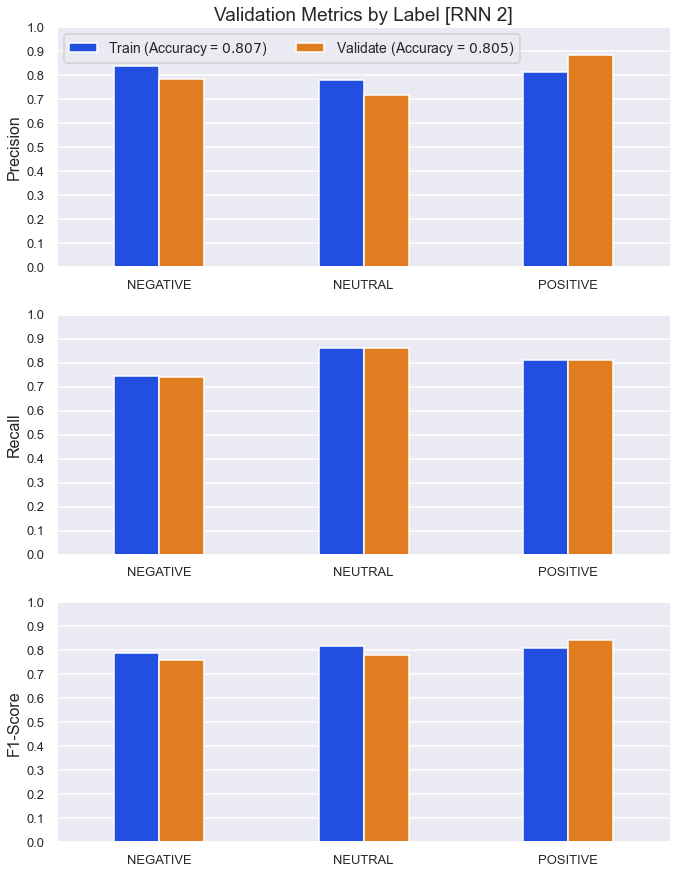

In [120]:
plot_validation_metrics_by_label(y_train_LE, 
                                     y_train_rnn2_pred, 
                                     y_validate_LE, 
                                     y_validate_rnn2_pred, 
                                     score_names=["precision", "recall", "f1-score"], 
                                     target_names=le.classes_, 
                                     estimator_label="RNN 2", 
                                     sample_weight=sample_weights,
                                     filepath="images/rnn2/validation-metrics-by-label.png")

In [121]:
rnn2_val_metrics = get_classification_metrics(y_validate_LE, 
                                                    y_validate_rnn2_pred, 
                                                    target_names=le.classes_)
rnn2_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.781,0.718,0.882,0.794
Recall,0.741,0.859,0.810,0.804
F1-Score,0.761,0.782,0.845,0.796
Accuracy,NaN,NaN,NaN,0.805


##### *`RNN 3`*

Epoch 1/100
2406/2406 [==============================] - 184s 76ms/step - loss: 0.6569 - accuracy: 0.7482 - val_loss: 0.6085 - val_accuracy: 0.7767
Epoch 2/100
2406/2406 [==============================] - 182s 76ms/step - loss: 0.5996 - accuracy: 0.7822 - val_loss: 0.5904 - val_accuracy: 0.7868
Epoch 3/100
2406/2406 [==============================] - 184s 76ms/step - loss: 0.5862 - accuracy: 0.7896 - val_loss: 0.5805 - val_accuracy: 0.7909
Epoch 4/100
2406/2406 [==============================] - 186s 77ms/step - loss: 0.5788 - accuracy: 0.7942 - val_loss: 0.5673 - val_accuracy: 0.7980
Epoch 5/100
2406/2406 [==============================] - 186s 77ms/step - loss: 0.5741 - accuracy: 0.7965 - val_loss: 0.5687 - val_accuracy: 0.7989
Epoch 6/100
2406/2406 [==============================] - 185s 77ms/step - loss: 0.5702 - accuracy: 0.7987 - val_loss: 0.5750 - val_accuracy: 0.7969
Epoch 7/100
2406/2406 [==============================] - 185s 77ms/step - loss: 0.5674 - accuracy: 0.8003 - val_

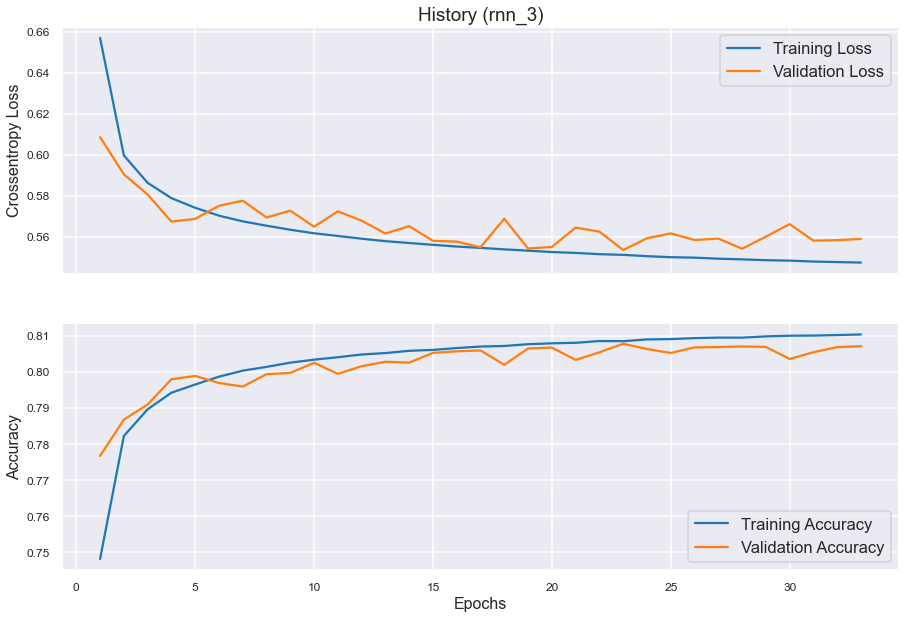

In [122]:
rnn_3 = Sequential(name="rnn_3")

rnn_3.add(embedding_layer)
rnn_3.add(Bidirectional(LSTM(16)))
rnn_3.add(Dense(3, activation='softmax'))

rnn_3.compile(optimizer="Adam",
                loss='categorical_crossentropy',
                metrics=['accuracy']) 


checkpoint = ModelCheckpoint(filepath="models/rnn3.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")

history_3 = rnn_3.fit(X_train_IE,
                         y_train_OHE,
                         batch_size=512,
                         epochs=100,
                         validation_data=(X_validate_IE, y_validate_OHE),
                         validation_batch_size=128,
                         sample_weight=sample_weights,
                         callbacks=[early_stopping, checkpoint])

plot_history(rnn_3.name, 
              history_3.history, 
              filepath="images/rnn3/history.png")

In [123]:
rnn_3 = load_model("models/rnn3.h5")

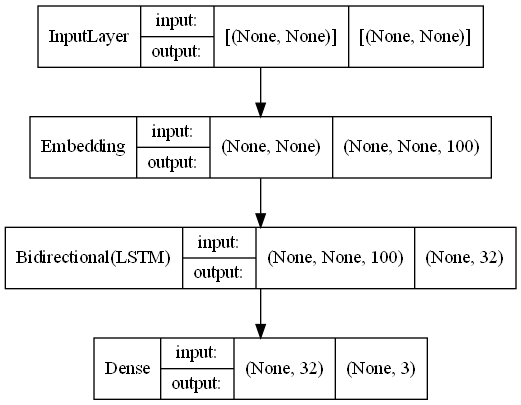

In [124]:
plot_model(rnn_3,
             to_file="images/rnn3/plot.png",
             show_shapes=True,
             show_layer_names=False)

In [125]:
y_train_rnn3_pred = rnn_3.predict(X_train_IE)
y_validate_rnn3_pred = rnn_3.predict(X_validate_IE)

y_train_rnn3_pred = le.transform(lb.inverse_transform(y_train_rnn3_pred))
y_validate_rnn3_pred = le.transform(lb.inverse_transform(y_validate_rnn3_pred))

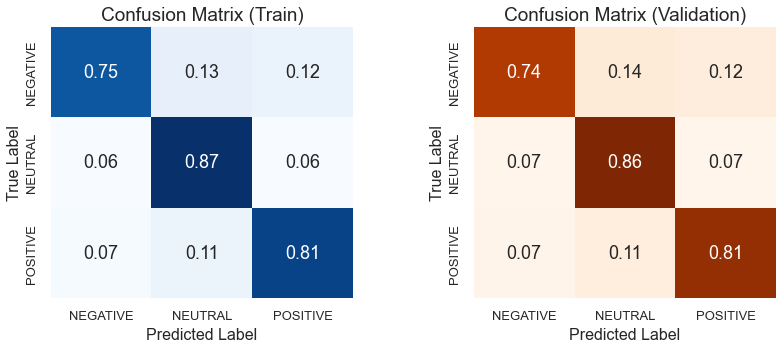

In [126]:
plot_confusion_matrices(y_train_LE, 
                            y_train_rnn3_pred, 
                            y_validate_LE, 
                            y_validate_rnn3_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/rnn3/validation-confusion-matrices.png")

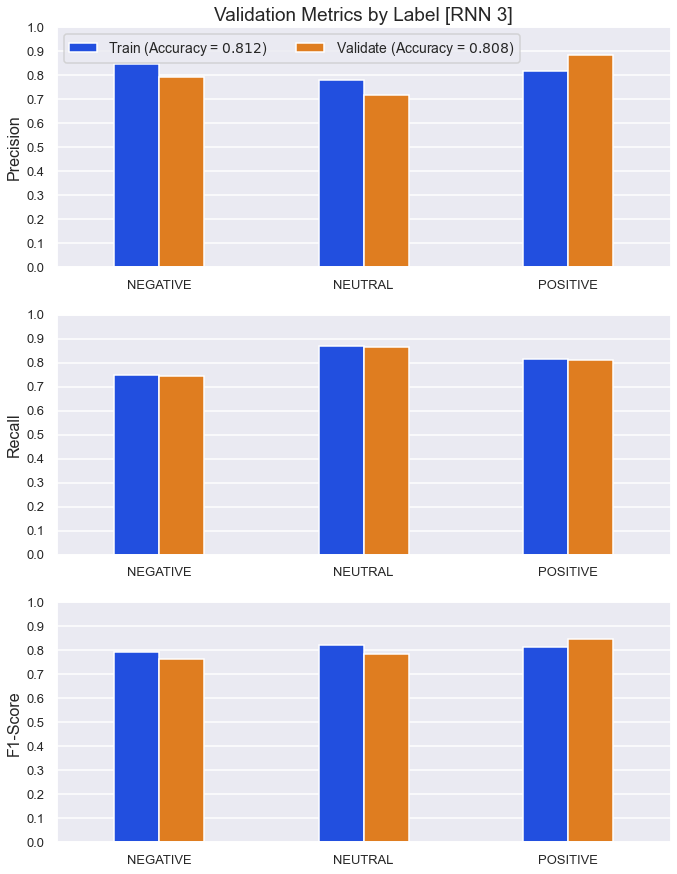

In [127]:
plot_validation_metrics_by_label(y_train_LE, 
                                     y_train_rnn3_pred, 
                                     y_validate_LE, 
                                     y_validate_rnn3_pred, 
                                     score_names=["precision", "recall", "f1-score"], 
                                     target_names=le.classes_, 
                                     estimator_label="RNN 3", 
                                     sample_weight=sample_weights,
                                     filepath="images/rnn3/validation-metrics-by-label.png")

In [128]:
rnn3_val_metrics = get_classification_metrics(y_validate_LE, 
                                                    y_validate_rnn3_pred, 
                                                    target_names=le.classes_)
rnn3_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.789,0.717,0.885,0.797
Recall,0.742,0.865,0.813,0.807
F1-Score,0.765,0.784,0.847,0.799
Accuracy,NaN,NaN,NaN,0.808


##### *`RNN 4`*

Epoch 1/100
2406/2406 [==============================] - 259s 106ms/step - loss: 0.6536 - accuracy: 0.7502 - val_loss: 0.6016 - val_accuracy: 0.7804
Epoch 2/100
2406/2406 [==============================] - 263s 109ms/step - loss: 0.5932 - accuracy: 0.7856 - val_loss: 0.5890 - val_accuracy: 0.7898
Epoch 3/100
2406/2406 [==============================] - 267s 111ms/step - loss: 0.5764 - accuracy: 0.7954 - val_loss: 0.5714 - val_accuracy: 0.7990
Epoch 4/100
2406/2406 [==============================] - 271s 113ms/step - loss: 0.5666 - accuracy: 0.8011 - val_loss: 0.5642 - val_accuracy: 0.8034
Epoch 5/100
2406/2406 [==============================] - 275s 114ms/step - loss: 0.5600 - accuracy: 0.8045 - val_loss: 0.5565 - val_accuracy: 0.8070
Epoch 6/100
2406/2406 [==============================] - 278s 115ms/step - loss: 0.5554 - accuracy: 0.8073 - val_loss: 0.5507 - val_accuracy: 0.8092
Epoch 7/100
2406/2406 [==============================] - 283s 118ms/step - loss: 0.5520 - accuracy: 0.8089

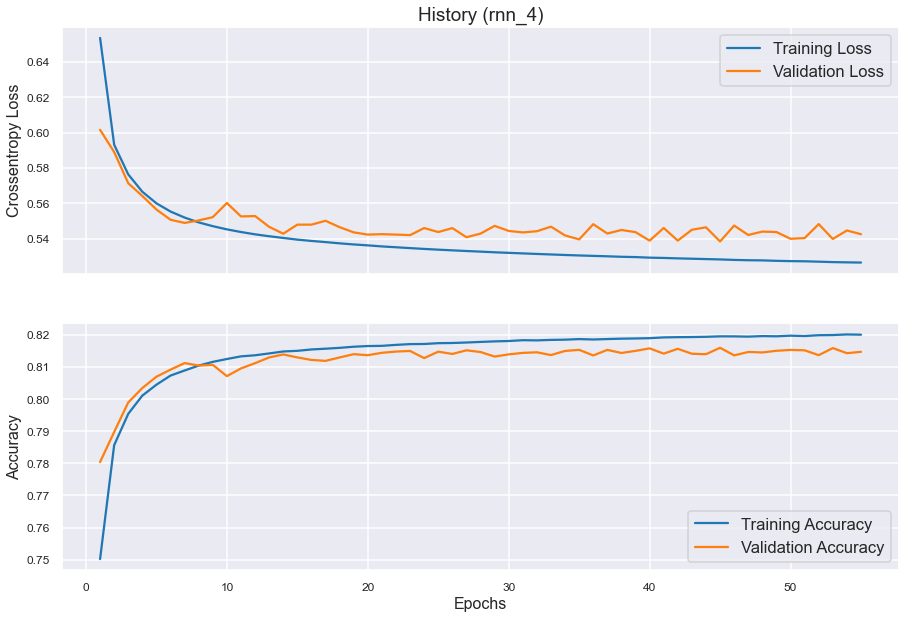

In [129]:
rnn_4 = Sequential(name="rnn_4")

rnn_4.add(embedding_layer)
rnn_4.add(Bidirectional(LSTM(16, return_sequences=True)))
rnn_4.add(Bidirectional(LSTM(8)))
rnn_4.add(Dense(3, activation='softmax'))

rnn_4.compile(optimizer="Adam",
                loss='categorical_crossentropy',
                metrics=['accuracy']) 


checkpoint = ModelCheckpoint(filepath="models/rnn4.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")

history_4 = rnn_4.fit(X_train_IE,
                         y_train_OHE,
                         batch_size=512,
                         epochs=100,
                         validation_data=(X_validate_IE, y_validate_OHE),
                         validation_batch_size=128,
                         sample_weight=sample_weights,
                         callbacks=[early_stopping, checkpoint])

plot_history(rnn_4.name, 
              history_4.history, 
              filepath="images/rnn4/history.png")

In [130]:
rnn_4 = load_model("models/rnn4.h5")

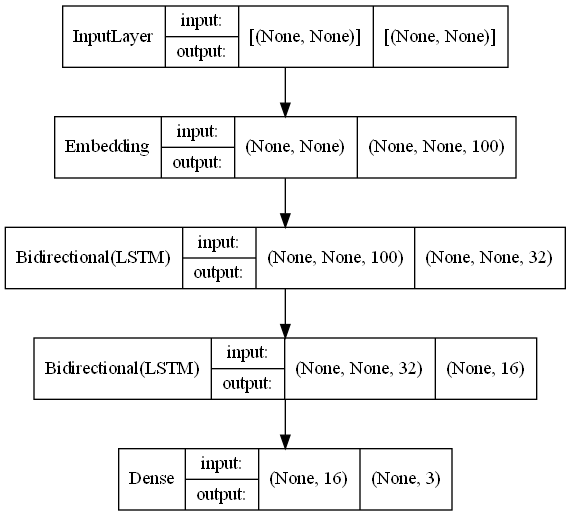

In [131]:
plot_model(rnn_4,
             to_file="images/rnn4/plot.png",
             show_shapes=True,
             show_layer_names=False)

In [132]:
y_train_rnn4_pred = rnn_4.predict(X_train_IE)
y_validate_rnn4_pred = rnn_4.predict(X_validate_IE)

y_train_rnn4_pred = le.transform(lb.inverse_transform(y_train_rnn4_pred))
y_validate_rnn4_pred = le.transform(lb.inverse_transform(y_validate_rnn4_pred))

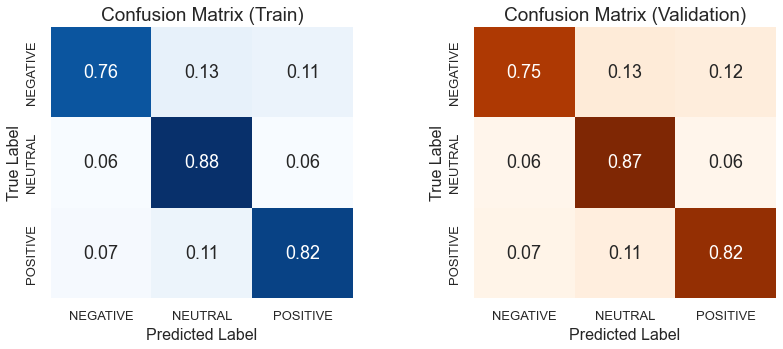

In [133]:
plot_confusion_matrices(y_train_LE, 
                            y_train_rnn4_pred, 
                            y_validate_LE, 
                            y_validate_rnn4_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/rnn4/validation-confusion-matrices.png")

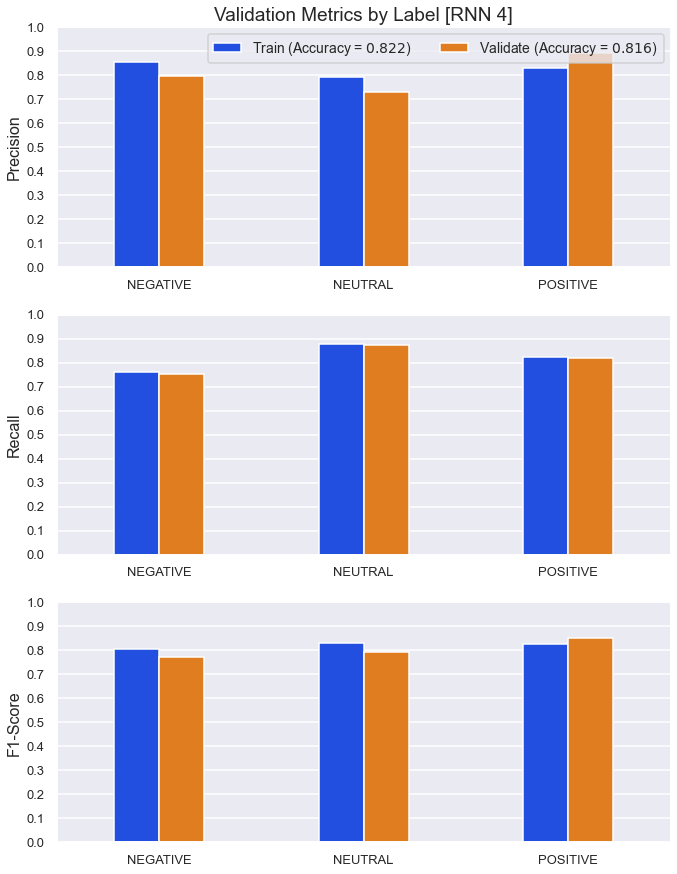

In [134]:
plot_validation_metrics_by_label(y_train_LE, 
                                     y_train_rnn4_pred, 
                                     y_validate_LE, 
                                     y_validate_rnn4_pred, 
                                     score_names=["precision", "recall", "f1-score"], 
                                     target_names=le.classes_, 
                                     estimator_label="RNN 4", 
                                     sample_weight=sample_weights,
                                     filepath="images/rnn4/validation-metrics-by-label.png")

In [135]:
rnn4_val_metrics = get_classification_metrics(y_validate_LE, 
                                                    y_validate_rnn4_pred, 
                                                    target_names=le.classes_)
rnn4_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.796,0.729,0.891,0.805
Recall,0.754,0.873,0.819,0.815
F1-Score,0.774,0.795,0.854,0.807
Accuracy,NaN,NaN,NaN,0.816


##### *`RNN 5`*

Epoch 1/100
2406/2406 [==============================] - 696s 287ms/step - loss: 0.6348 - accuracy: 0.7624 - val_loss: 0.5968 - val_accuracy: 0.7855
Epoch 2/100
2406/2406 [==============================] - 630s 262ms/step - loss: 0.5743 - accuracy: 0.7969 - val_loss: 0.5663 - val_accuracy: 0.8028
Epoch 3/100
2406/2406 [==============================] - 698s 290ms/step - loss: 0.5586 - accuracy: 0.8057 - val_loss: 0.5559 - val_accuracy: 0.8071
Epoch 4/100
2406/2406 [==============================] - 738s 307ms/step - loss: 0.5505 - accuracy: 0.8100 - val_loss: 0.5519 - val_accuracy: 0.8103
Epoch 5/100
2406/2406 [==============================] - 744s 309ms/step - loss: 0.5449 - accuracy: 0.8129 - val_loss: 0.5504 - val_accuracy: 0.8114
Epoch 6/100
2406/2406 [==============================] - 757s 315ms/step - loss: 0.5411 - accuracy: 0.8145 - val_loss: 0.5526 - val_accuracy: 0.8094
Epoch 7/100
2406/2406 [==============================] - 773s 321ms/step - loss: 0.5379 - accuracy: 0.8160

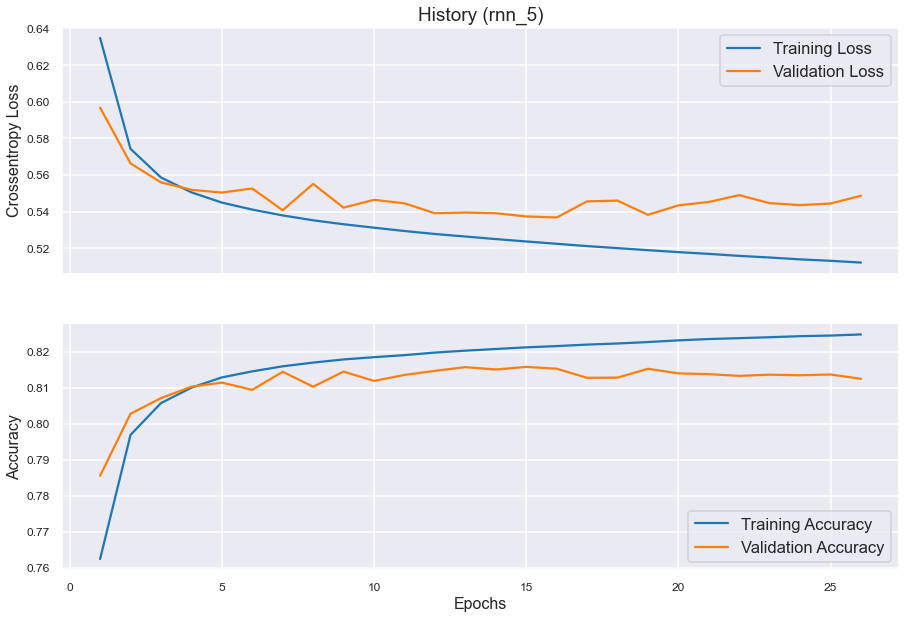

In [136]:
rnn_5 = Sequential(name="rnn_5")

rnn_5.add(embedding_layer)
rnn_5.add(Bidirectional(LSTM(32, return_sequences=True)))
rnn_5.add(Bidirectional(LSTM(16, return_sequences=True)))
rnn_5.add(Bidirectional(LSTM(8)))
rnn_5.add(Dense(3, activation='softmax'))

rnn_5.compile(optimizer="Adam",
                loss='categorical_crossentropy',
                metrics=['accuracy']) 


checkpoint = ModelCheckpoint(filepath="models/rnn5.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")

history_5 = rnn_5.fit(X_train_IE,
                         y_train_OHE,
                         batch_size=512,
                         epochs=100,
                         validation_data=(X_validate_IE, y_validate_OHE),
                         validation_batch_size=128,
                         sample_weight=sample_weights,
                         callbacks=[early_stopping, checkpoint])

plot_history(rnn_5.name, 
              history_5.history, 
              filepath="images/rnn5/history.png")

In [137]:
rnn_5 = load_model("models/rnn5.h5")

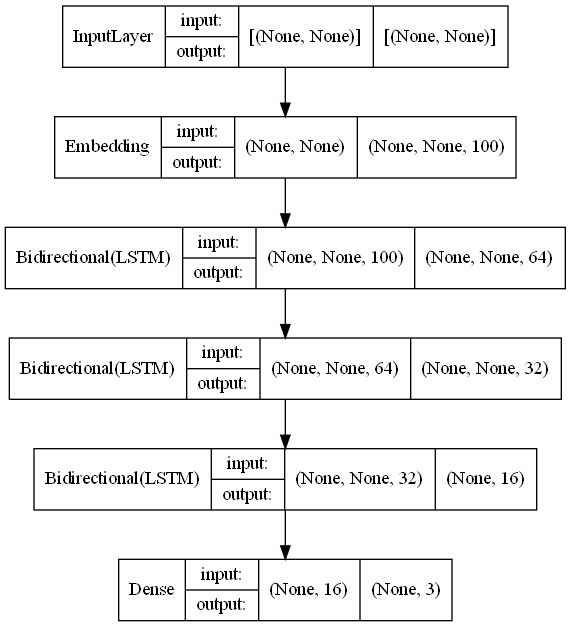

In [138]:
plot_model(rnn_5,
             to_file="images/rnn5/plot.png",
             show_shapes=True,
             show_layer_names=False)

In [139]:
y_train_rnn5_pred = rnn_5.predict(X_train_IE)
y_validate_rnn5_pred = rnn_5.predict(X_validate_IE)

y_train_rnn5_pred = le.transform(lb.inverse_transform(y_train_rnn5_pred))
y_validate_rnn5_pred = le.transform(lb.inverse_transform(y_validate_rnn5_pred))

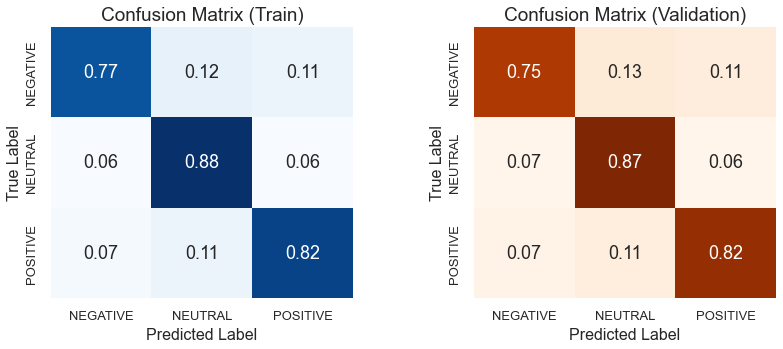

In [140]:
plot_confusion_matrices(y_train_LE, 
                            y_train_rnn5_pred, 
                            y_validate_LE, 
                            y_validate_rnn5_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            figsize=(13,5),
                            filepath="images/rnn5/validation-confusion-matrices.png")

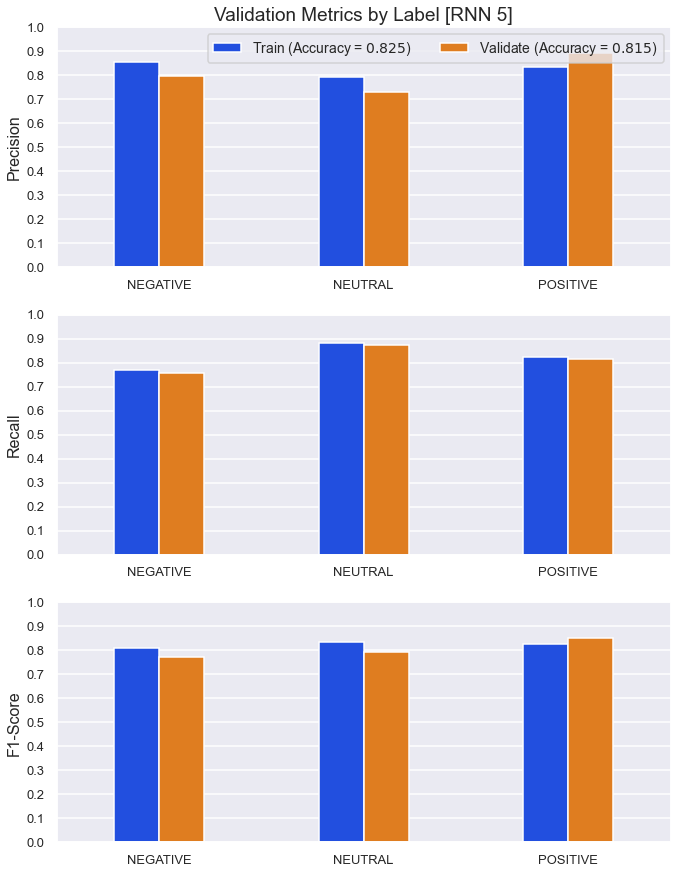

In [141]:
plot_validation_metrics_by_label(y_train_LE, 
                                     y_train_rnn5_pred, 
                                     y_validate_LE, 
                                     y_validate_rnn5_pred, 
                                     score_names=["precision", "recall", "f1-score"], 
                                     target_names=le.classes_, 
                                     estimator_label="RNN 5", 
                                     sample_weight=sample_weights,
                                     filepath="images/rnn5/validation-metrics-by-label.png")

In [142]:
rnn5_val_metrics = get_classification_metrics(y_validate_LE, 
                                                    y_validate_rnn5_pred, 
                                                    target_names=le.classes_)
rnn5_val_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.794,0.727,0.893,0.804
Recall,0.755,0.874,0.817,0.815
F1-Score,0.774,0.794,0.853,0.807
Accuracy,NaN,NaN,NaN,0.815


### *D.4.3 - Selecting the Best Architecture*

In [143]:
rnn_names = ["RNN 1",
                "RNN 2",
                "RNN 3",
                "RNN 4",
                "RNN 5"]

In [144]:
rnn_metrics =  [rnn1_val_metrics,
                  rnn2_val_metrics,
                  rnn3_val_metrics,
                  rnn4_val_metrics,
                  rnn5_val_metrics]

The average validation metrics for `RNN 1`, `RNN 2`, `RNN 3`, `RNN 4`, and `RNN 5` are listed in the table below:

In [145]:
rnn_overall_metrics_df = pd.DataFrame(dict(zip(rnn_names, [dict(metrics_df.loc[metrics_df.index, "Average"]) for metrics_df in rnn_metrics])))
rnn_overall_metrics_df.rename(index={"Precision": "Precision (Average)", "Recall": "Recall (Average)", "F1-Score": "F1-Score (Average)"}, inplace=True)
rnn_overall_metrics_df = rnn_overall_metrics_df.T
rnn_overall_metrics_df

,Precision (Average),Recall (Average),F1-Score (Average),Accuracy
RNN 1,0.781,0.794,0.783,0.792
RNN 2,0.794,0.804,0.796,0.805
RNN 3,0.797,0.807,0.799,0.808
RNN 4,0.805,0.815,0.807,0.816
RNN 5,0.804,0.815,0.807,0.815


A plot of the average $F_1\text{-Score}$ on the Validation Set for `RNN 1`, `RNN 2`, `RNN 3`, `RNN 4`, and `RNN 5` is shown below:

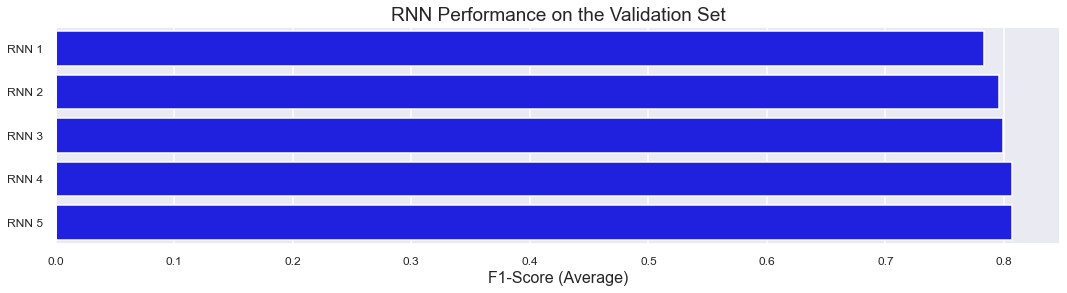

In [146]:
fig, ax = plt.subplots(figsize=(18,4))
sns.barplot(x=rnn_overall_metrics_df["F1-Score (Average)"], y=rnn_overall_metrics_df.index, color="blue", ax=ax)
ax.set(title='RNN Performance on the Validation Set')
plt.show()
fig.savefig("images/overall-metrics/rnn-f1-scores.png")

> The above two figures show that `RNN 4` and `RNN 5` achieved almost identical scores on the Validation Set, despite the fact that `RNN 5` had an additional bidirectional LSTM layer containing $32$ neurons. `RNN 4` was chosen as the final RNN because its simpler architecture means that it is computationally faster and has less variance (and therefore a better ability to generalize to unseen data) than `RNN 5`.

## *D.5 - Selecting the Best Model*

In [147]:
model_names = ["Naive Bayes",
                   "Random Forest",
                   "Logistic Regression",
                   "RNN 4"]

In [148]:
metrics_list = [mnb_val_metrics,
                  rfc_val_metrics,
                  logreg_val_metrics,
                  rnn4_val_metrics]

The average validation metrics for the `Naive Bayes`, `Random Forest`, `Logistic Regression`, and `RNN 4` models are listed in the table below:

In [149]:
overall_metrics_df = pd.DataFrame(dict(zip(model_names, [dict(metrics_df.loc[metrics_df.index, "Average"]) for metrics_df in metrics_list])))
overall_metrics_df.rename(index={"Precision": "Precision (Average)", "Recall": "Recall (Average)", "F1-Score": "F1-Score (Average)"}, inplace=True)
overall_metrics_df = overall_metrics_df.T.sort_values(by="F1-Score (Average)", ascending=False)
overall_metrics_df

,Precision (Average),Recall (Average),F1-Score (Average),Accuracy
RNN 4,0.805,0.815,0.807,0.816
Logistic Regression,0.797,0.811,0.800,0.808
Random Forest,0.769,0.770,0.757,0.766
Naive Bayes,0.744,0.757,0.748,0.757


A plot of the average $F_1\text{-Score}$ on the Validation Set for the `Naive Bayes`, `Random Forest`, `Logistic Regression`, and `RNN 4` models is shown below:

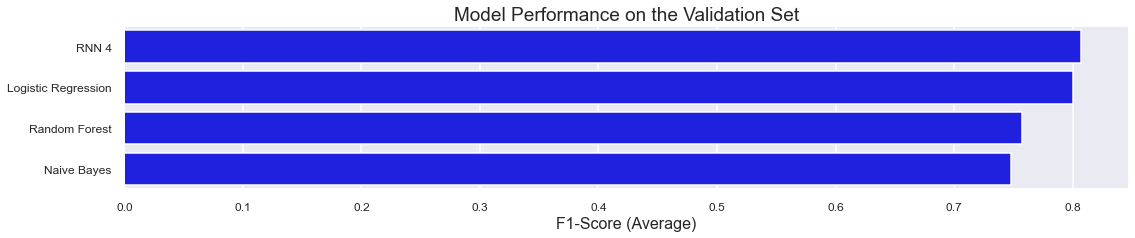

In [150]:
fig, ax = plt.subplots(figsize=(18,3))
sns.barplot(x=overall_metrics_df["F1-Score (Average)"], y=overall_metrics_df.index, color="blue", ax=ax)
ax.set(title='Model Performance on the Validation Set')
plt.show()
fig.savefig("images/overall-metrics/f1-scores.png")

> The two figures above show that `RNN 4` had the highest $F_1\text{-Score}$ and $\text{Accuracy}$ on the Validation Set, and therefore was chosen as the best model. A final evaluation of this model was carried out by assessing its performance on the Test Set.

# E. *Evaluation*

## *E.1 - Evaluating the Performance of __`RNN 4`__ on the Test Set*

In [151]:
y_test_rnn4_pred = rnn_4.predict(X_test_IE)

In [152]:
y_test_rnn4_pred = le.transform(lb.inverse_transform(y_test_rnn4_pred))
y_test_rnn4_pred

array([0, 2, 0, ..., 2, 0, 0])

The performances of the `RNN 4` model on the Training Set and Test Set are compared in the plots below:

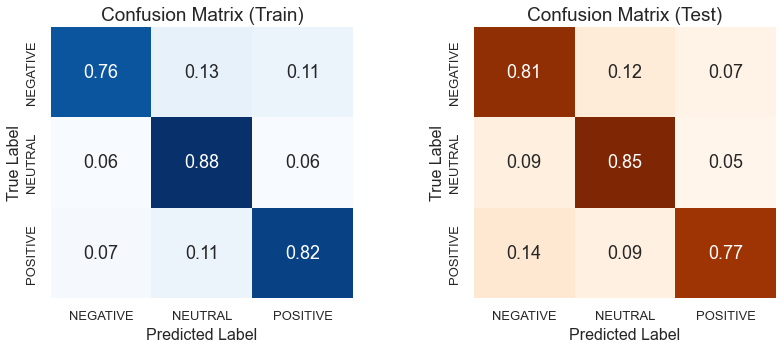

In [153]:
plot_confusion_matrices(y_train_LE, 
                            y_train_rnn4_pred, 
                            y_test_LE, 
                            y_test_rnn4_pred, 
                            labels=le.classes_, 
                            normalize="true", 
                            sample_weights=sample_weights,
                            mode="test",
                            figsize=(13,5),
                            filepath="images/rnn4/test-confusion-matrices.png")

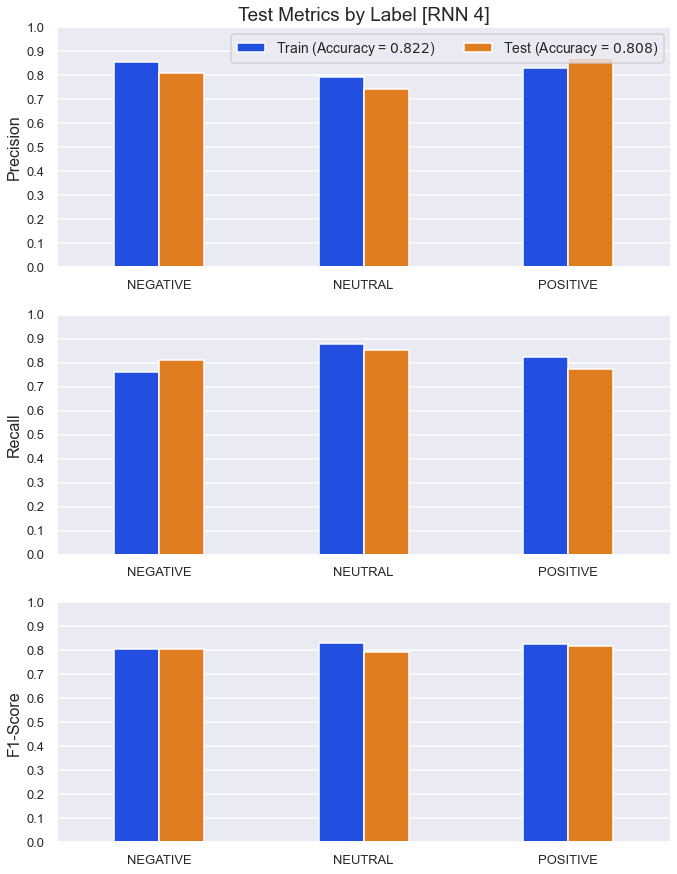

In [154]:
plot_validation_metrics_by_label(y_train_LE, 
                           y_train_rnn4_pred, 
                           y_test_LE, 
                           y_test_rnn4_pred, 
                           score_names=["precision", "recall", "f1-score"], 
                           target_names=le.classes_, 
                           estimator_label="RNN 4", 
                           sample_weight=sample_weights,
                           mode="test",
                           filepath="images/rnn4/test-metrics-by-label.png")

The scores achieved by the `RNN 4` model on the Test Set are listed fully in the table below:

In [155]:
rnn4_test_metrics = get_classification_metrics(y_test_LE, 
                                                      y_test_rnn4_pred, 
                                                      target_names=le.classes_)
rnn4_test_metrics

,NEGATIVE,NEUTRAL,POSITIVE,Average
Precision,0.807,0.742,0.869,0.806
Recall,0.809,0.853,0.774,0.812
F1-Score,0.808,0.794,0.819,0.807
Accuracy,NaN,NaN,NaN,0.808


The performance of `RNN 4` on the Test Set is summarized as follows:

> - Adequate recall when classifying POSITIVE tweets:
>   - $74\%$ of all POSITIVE tweets in the Test Set were labeled correctly
> - Very good precision when classifying POSITIVE tweets:
>   - $87\%$ of all POSITIVE predictions made by the model were correct
> - Good overall performance on the POSITIVE tweets $(F_{1, \text{POSITIVE}} = 0.798)$
---
> - Very good recall when classifying NEUTRAL tweets:
>   - $87\%$ of all NEUTRAL tweets in the Test Set were labeled correctly
> - Adequate precision when classifying NEUTRAL tweets:
>   - $73\%$ of all NEUTRAL predictions made by the model were correct
> - Good overall performance on the NEUTRAL tweets $(F_{1, \text{NEUTRAL}} = 0.796)$
---
> - Good recall when classifying NEGATIVE tweets:
>   - $80\%$ of all NEGATIVE tweets in the Test Set were labeled correctly
> - Good precision when classifying NEGATIVE tweets:
>   - $80\%$ of all NEGATIVE predictions made by the model were correct
> - Good overall performance on the NEGATIVE tweets $(F_{1, \text{NEGATIVE}} = 0.799)$
---
> - Overall, the model had a solid performance on the Test Set:
>   - $F_{1,\text{avg}} = 0.798$
> - The model's ability to generalize to unseen data needs some improvement:
>   - $2.3\%$ loss in accuracy indicates some overfitting

## *E.2 - Comparing the Approval Ratings Predicted by `RNN 4` with Traditional Polling Data*

### *E.2.1 - Calculating Approval Ratings from Twitter Sentiment Data*

> In order to calculate approval ratings based on Twitter sentiment data, all `NEUTRAL` tweets were discarded. This was done for the following reasons:
> * a `NEUTRAL` tweet does not necessarily mean that the author has no opinion towards Joe Biden, whereas it is reasonable to assume that a tweet with a `POSITIVE`/`NEGATIVE` sentiment corresponds with the author's overall attitude towards the president
> * a significant number of `NEUTRAL` tweets in the *Test Corpus* were some kind of news outlet reporting on a situation involving Joe Biden, as opposed to an individual expressing their views, and so were not valid as polling data
>
> Given some collection of sentiment data containing $N_{P}$ `POSITIVE` labels and $N_{N}$ `NEGATIVE` labels, the associated **approval rating** and **disapproval rating** were determined from the following formulas:
> $$ \text{Approval\ Rating} = (\dfrac{N_{P}}{N_{P} + N_{N}}) * 100\% $$
> $$ \text{Disapproval\ Rating} = (\dfrac{N_{N}}{N_{P} + N_{N}}) * 100\% $$

In [219]:
test_predictions = pd.Series(le.inverse_transform(y_test_rnn4_pred))
test_predictions

0        NEGATIVE
1        POSITIVE
2        NEGATIVE
3        POSITIVE
4        POSITIVE
           ...   
92657    POSITIVE
92658     NEUTRAL
92659    POSITIVE
92660    NEGATIVE
92661    NEGATIVE
Length: 92662, dtype: object

In [220]:
test_corpus["predicted_label"] = test_predictions
test_corpus.head()

,user_location,sentiment_multiplier,tokens,label,predicted_label
0,TX,1,policy systematic land confiscation ally apply tigray tigrayans civilian force thier land semera desert concentration camp,NEGATIVE,NEGATIVE
1,<NA>,1,bloomberg president biden win dismissal lawsuit white house press secretary spicer fire board naval academy advise commander chief story,POSITIVE,POSITIVE
2,WA,1,democrat failure complete create job reduce covid death pass american rescue plan bipartisan infrastructure confirm judge judge jfk close historic deal rx drug failure,POSITIVE,NEGATIVE
3,<NA>,1,manchin foolish think gain favor gop voter vote gop dems foolish green policy gain favor profit coal foolish think wait sort,POSITIVE,POSITIVE
4,<NA>,2,fair year ago glut supply pandemic cheering price record highs record high year ago definitely stuff,POSITIVE,POSITIVE


In [221]:
test_labels_df = test_corpus.loc[:,["user_location", "sentiment_multiplier", "predicted_label"]]
test_labels_df

,user_location,sentiment_multiplier,predicted_label
0,TX,1,NEGATIVE
1,<NA>,1,POSITIVE
2,WA,1,NEGATIVE
3,<NA>,1,POSITIVE
4,<NA>,2,POSITIVE
...,...,...,...
92657,<NA>,2,POSITIVE
92658,<NA>,2,NEUTRAL
92659,<NA>,2,POSITIVE
92660,<NA>,1,NEGATIVE


In [222]:
label_counts = {}
label_counts["overall"] = Counter()
with open("data/us_states.csv") as file_iter:
    for row in file_iter.readlines():
        state_id, _ = map(str.strip, row.split(','))
        label_counts[state_id] = Counter()

In [223]:
for row in test_labels_df.itertuples():
    label = row.predicted_label
    count = row.sentiment_multiplier
    location = row.user_location
    
    label_counts["overall"][label] += count
    
    if location is not pd.NA:
        label_counts[location][label] += 1

In [224]:
sentiment_counts = {}
for location in label_counts:
    sentiment_counts[location] = label_counts[location]["POSITIVE"] + label_counts[location]["NEGATIVE"]

In [225]:
approval_ratings = {}
for location, counter in label_counts.items():
    approval_ratings[location] = {}
    temp_label_counts = dict(counter)
    temp_label_counts.pop("NEUTRAL")
    temp_sentiment_count = sentiment_counts[location]
    for label, count in temp_label_counts.items():
        if label == "NEGATIVE":
            approval_ratings[location]["Disapprove [%]"] = (count / temp_sentiment_count) * 100
        elif label == "POSITIVE":
            approval_ratings[location]["Approve [%]"] = (count / temp_sentiment_count) * 100

## *E.3 - Plotting Approval Ratings*

### *E.3.1 - Overall Approval Ratings*

In [226]:
overall_approval_ratings = {}
overall_approval_ratings["Twitter Sentiment Analysis"] = approval_ratings["overall"]
overall_approval_ratings["Twitter Sentiment Analysis"]["Unsure/No Opinion [%]"] = 0

All of the following approval ratings were gathered from a project that tracks Joe Biden's approval rating in real time. The project was created and is currently maintained by [*FiveThirtyEight*](https://fivethirtyeight.com), a journalism website that uses data driven analytics to make predictions about politics, economics, and sports in the United States. The webpage hosting the project contains a constantly updated aggregate of opinion polls sourced from a myriad of different organizations and research groups. The approval ratings from $10$ of these polls were collected and compared to the results predicted by `RNN 4`. All polls chosen ocurred within, or over a period of time overlapping, the same week within which all tweets in the *Test Corpus* were created (July 12, 2022 - July 19, 2022). The webpage hosting this project is cited below:

> Silver, N. (2021, January 23). *How popular is Joe Biden?* FiveThirtyEight. Retrieved August 5, 2022, from https://projects.fivethirtyeight.com/biden-approval-rating/

In [227]:
overall_approval_ratings["Greenberg Research"] = {"Approve [%]": 42, "Disapprove [%]": 58, "Unsure/No Opinion [%]": 0}
overall_approval_ratings["Big Village"] = {"Approve [%]": 39, "Disapprove [%]": 55, "Unsure/No Opinion [%]": 6}
overall_approval_ratings["Marist College"] = {"Approve [%]": 36, "Disapprove [%]": 57, "Unsure/No Opinion [%]": 7}
overall_approval_ratings["Morning Consult"] = {"Approve [%]": 39, "Disapprove [%]": 57, "Unsure/No Opinion [%]": 4}
overall_approval_ratings["Navigator Research"] = {"Approve [%]": 43, "Disapprove [%]": 55, "Unsure/No Opinion [%]": 2}
overall_approval_ratings["Quinnipiac University"] = {"Approve [%]": 35, "Disapprove [%]": 59, "Unsure/No Opinion [%]": 6}
overall_approval_ratings["Echelon Insights"] = {"Approve [%]": 41, "Disapprove [%]": 57, "Unsure/No Opinion [%]": 2}
overall_approval_ratings["Rasmussen Reports"] = {"Approve [%]": 42, "Disapprove [%]": 57, "Unsure/No Opinion [%]": 1}
overall_approval_ratings["Beacon Research"] = {"Approve [%]": 40, "Disapprove [%]": 59, "Unsure/No Opinion [%]": 1}
overall_approval_ratings["Lake Research Partners"] = {"Approve [%]": 42, "Disapprove [%]": 55, "Unsure/No Opinion [%]": 3}

In [228]:
overall_approval_ratings_df = pd.DataFrame(overall_approval_ratings).T
overall_approval_ratings_df = overall_approval_ratings_df.astype("int16")
overall_approval_ratings_df["Net Approval [%]"] = overall_approval_ratings_df["Approve [%]"] - overall_approval_ratings_df["Disapprove [%]"]
overall_approval_ratings_df = overall_approval_ratings_df.loc[:,["Approve [%]", "Disapprove [%]", "Unsure/No Opinion [%]", "Net Approval [%]"]]
overall_approval_ratings_df

,Approve [%],Disapprove [%],Unsure/No Opinion [%],Net Approval [%]
Twitter Sentiment Analysis,45,54,0,-9
Greenberg Research,42,58,0,-16
Big Village,39,55,6,-16
Marist College,36,57,7,-21
Morning Consult,39,57,4,-18
Navigator Research,43,55,2,-12
Quinnipiac University,35,59,6,-24
Echelon Insights,41,57,2,-16
Rasmussen Reports,42,57,1,-15
Beacon Research,40,59,1,-19


The approval ratings from $10$ of these polls were collected and compared to the results predicted by `RNN 4`, as shown in the plots below:

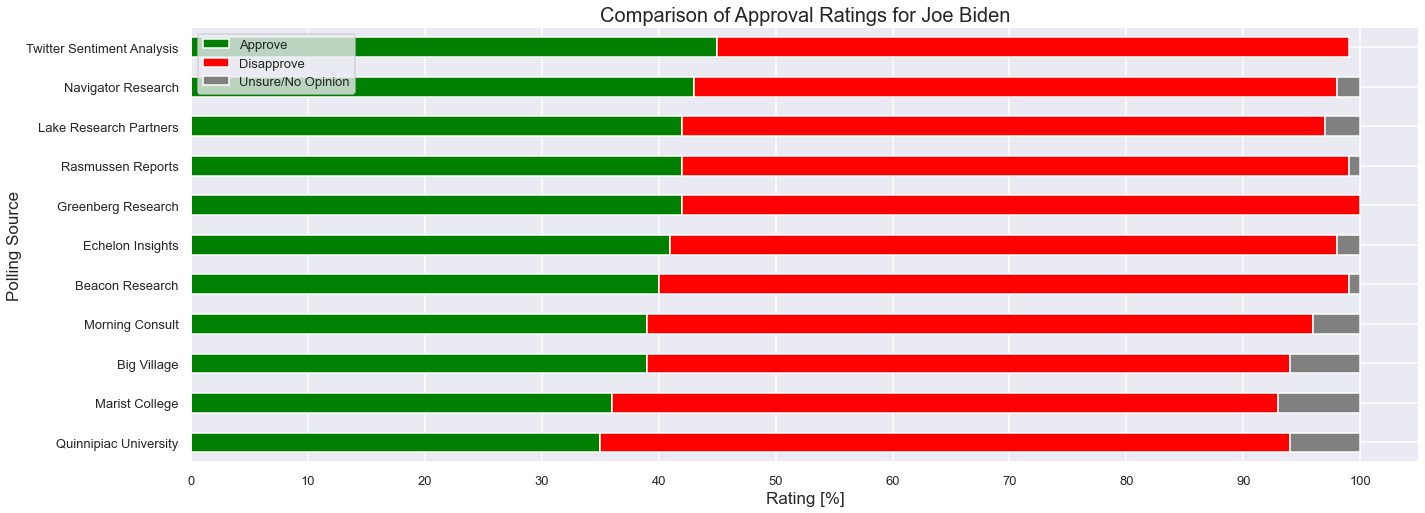

In [229]:
overall_approval_ratings_df.sort_values(by="Approve [%]", ascending=True, inplace=True)

fig, ax = plt.subplots()
overall_approval_ratings_df.loc[:,["Approve [%]", "Disapprove [%]", "Unsure/No Opinion [%]"]].plot(kind="barh", 
                                                                                                                  stacked=True, 
                                                                                                                  color=["green", "red", "grey"],
                                                                                                                  title="Comparison of Approval Ratings for Joe Biden",
                                                                                                                  ylabel="Polling Source",
                                                                                                                  figsize=(22,8),
                                                                                                                  ax=ax)
ax.set(xlabel="Rating [%]")
ax.legend(["Approve", "Disapprove", "Unsure/No Opinion"], prop={'size': 13})
ax.xaxis.set_major_locator(MultipleLocator(base=10))

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20

fig.savefig("images/approval-ratings.png")

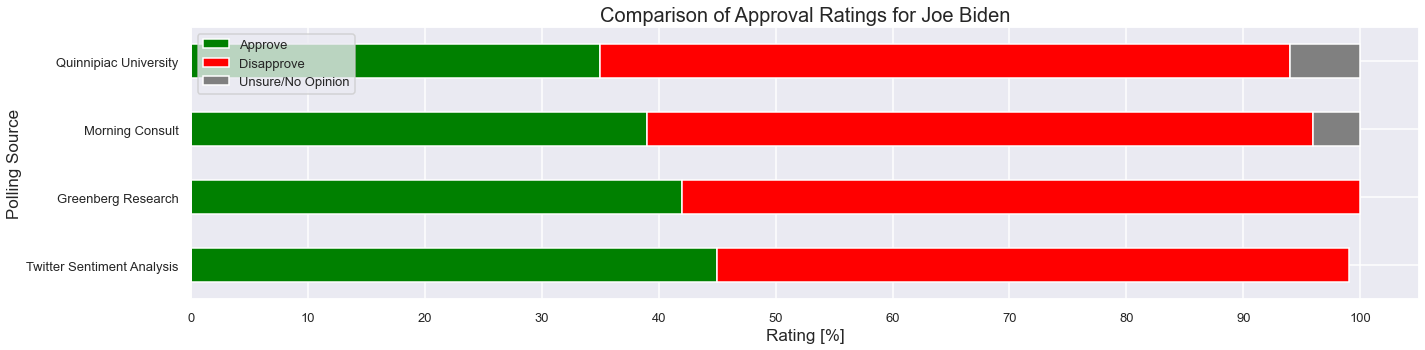

In [230]:
overall_approval_ratings_df.sort_values(by="Approve [%]", ascending=True, inplace=True)

fig, ax = plt.subplots()
overall_approval_ratings_df.loc[["Twitter Sentiment Analysis", "Greenberg Research", "Morning Consult", "Quinnipiac University"],["Approve [%]", "Disapprove [%]", "Unsure/No Opinion [%]"]].plot(kind="barh", 
                                                                                                                                                                                                                            stacked=True, 
                                                                                                                                                                                                                            color=["green", "red", "grey"],
                                                                                                                                                                                                                            title="Comparison of Approval Ratings for Joe Biden",
                                                                                                                                                                                                                            ylabel="Polling Source",
                                                                                                                                                                                                                            figsize=(22,5),
                                                                                                                                                                                                                            ax=ax)
ax.set(xlabel="Rating [%]")
ax.legend(["Approve", "Disapprove", "Unsure/No Opinion"], prop={'size': 13})
ax.xaxis.set_major_locator(MultipleLocator(base=10))

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20

fig.savefig("images/approval-ratings-condensed.png")

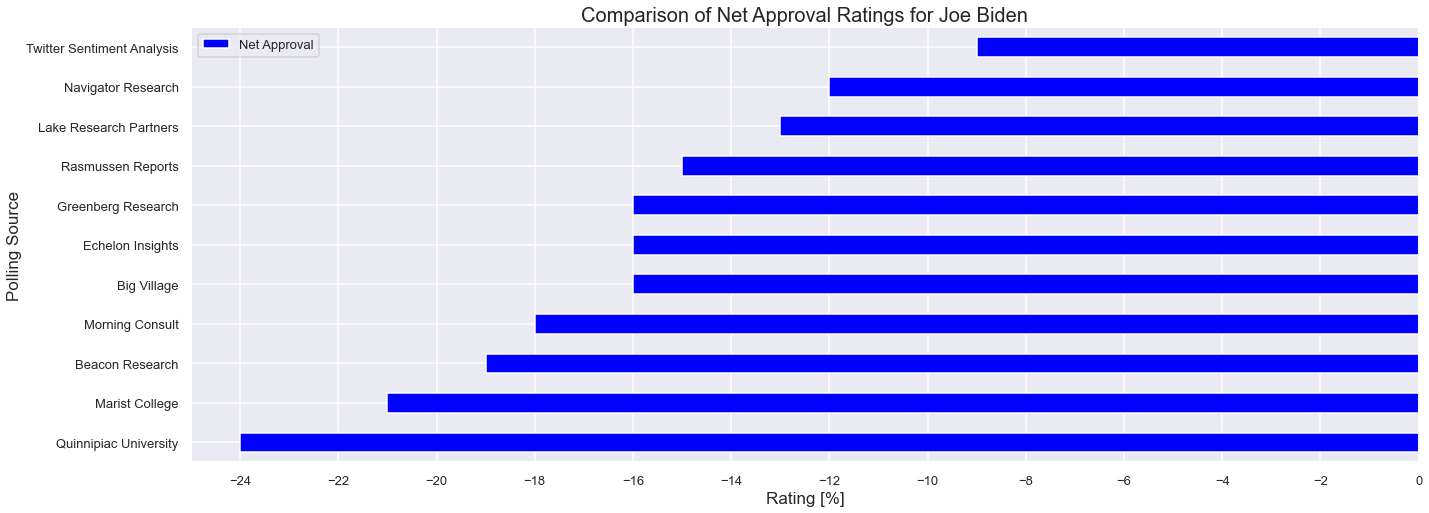

In [231]:
overall_approval_ratings_df.sort_values(by="Net Approval [%]", ascending=True, inplace=True)

fig, ax = plt.subplots()
overall_approval_ratings_df.loc[:,"Net Approval [%]"].plot(kind="barh", 
                                                                  color="blue",
                                                                  title="Comparison of Net Approval Ratings for Joe Biden",
                                                                  ylabel="Polling Source",
                                                                  figsize=(22,8),
                                                                  ax=ax)
ax.set(xlabel="Rating [%]", xlim=(-25,0))
ax.legend(["Net Approval"], prop={'size': 13})
ax.xaxis.set_major_locator(MultipleLocator(base=2))

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20

fig.savefig("images/net-approval-ratings.png")

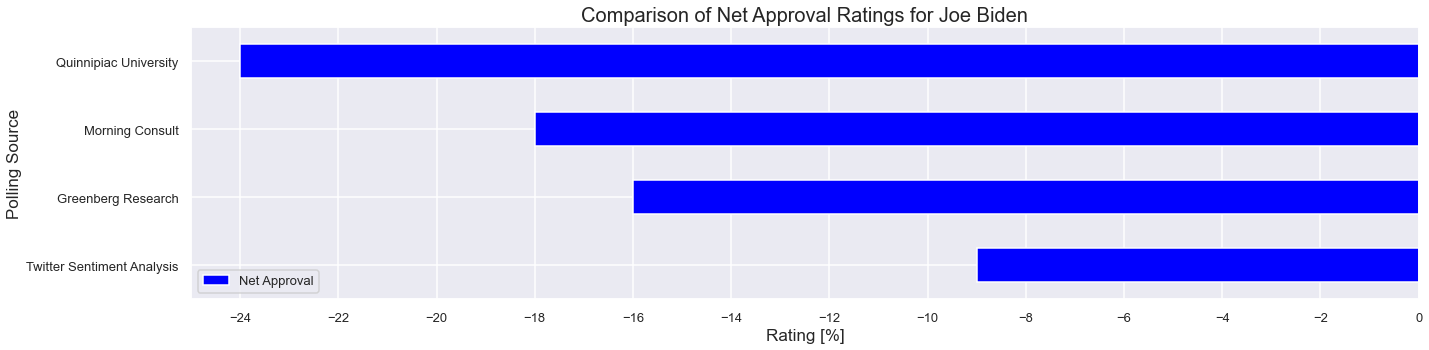

In [232]:
overall_approval_ratings_df.sort_values(by="Net Approval [%]", ascending=True, inplace=True)

fig, ax = plt.subplots()
overall_approval_ratings_df.loc[["Twitter Sentiment Analysis", "Greenberg Research", "Morning Consult", "Quinnipiac University"],"Net Approval [%]"].plot(kind="barh", 
                                                                                                                                                                             color="blue",
                                                                                                                                                                             title="Comparison of Net Approval Ratings for Joe Biden",
                                                                                                                                                                             ylabel="Polling Source",
                                                                                                                                                                             figsize=(22,5),
                                                                                                                                                                             ax=ax)
ax.set(xlabel="Rating [%]", xlim=(-25,0))
ax.legend(["Net Approval"], prop={'size': 13})
ax.xaxis.set_major_locator(MultipleLocator(base=2))

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20

fig.savefig("images/net-approval-ratings-condensed.png")

### *E.3.2 - State Approval Ratings*

In [233]:
state_approval_ratings = approval_ratings
if "overall" in state_approval_ratings:
    state_approval_ratings.pop("overall")
state_approval_ratings_df = pd.DataFrame(state_approval_ratings).T
state_approval_ratings_df["Net Approval [%] (Twitter Sentiment Analysis)"] = state_approval_ratings_df["Approve [%]"] - state_approval_ratings_df["Disapprove [%]"]
state_approval_ratings_df.drop(columns=["Approve [%]", "Disapprove [%]"], inplace=True)
state_approval_ratings_df[ "Net Approval [%] (Twitter Sentiment Analysis)"] = state_approval_ratings_df["Net Approval [%] (Twitter Sentiment Analysis)"].apply(lambda x: int(round(x,0)))

The following values entered into `state_approval_ratings_df` are the __net approval ratings__ for each state, sourced from the political forecasting website [*RacetotheWH*](https://www.racetothewh.com). Similar to *FiveThirtyEight*, all of the following data gathered from a webpage that tracks Joe Biden's approval ratings in real time by aggregating a variety of opinion polls sourced from a similarly wide variety of pollsters. However, *RacetotheWH* also organizes these polls by state. For each of the $50$ states, a poll conducted during the same the *Test Corpus* was compiled (July 12, 2022 - July 19, 2022) was chosen. If a poll with such a date was not present, than the poll with closest associated date was chosen. **It should be noted that some of the smaller states had relatively few polls listed, which at times necessitated choosing a poll that had been conducted weeks before or after the time during which the *Test Corpus* was compiled.** The webpage hosting this project is cited below: 


> Phillips, L. (n.d.). *How popular is Joe Biden?* Race to the WH. Retrieved September 6, 2022, from https://www.racetothewh.com/biden

In [234]:
state_approval_ratings_df.loc["AZ", "Net Approval [%] (Traditional Polling Data)"] = -12
state_approval_ratings_df.loc["AK", "Net Approval [%] (Traditional Polling Data)"] = -17
state_approval_ratings_df.loc["AL", "Net Approval [%] (Traditional Polling Data)"] = -25
state_approval_ratings_df.loc["AR", "Net Approval [%] (Traditional Polling Data)"] = -24
state_approval_ratings_df.loc["CA", "Net Approval [%] (Traditional Polling Data)"] = 0
state_approval_ratings_df.loc["CO", "Net Approval [%] (Traditional Polling Data)"] = -17
state_approval_ratings_df.loc["CT", "Net Approval [%] (Traditional Polling Data)"] = 10
state_approval_ratings_df.loc["DE", "Net Approval [%] (Traditional Polling Data)"] = 8
state_approval_ratings_df.loc["FL", "Net Approval [%] (Traditional Polling Data)"] = -15
state_approval_ratings_df.loc["GA", "Net Approval [%] (Traditional Polling Data)"] = -15
state_approval_ratings_df.loc["HI", "Net Approval [%] (Traditional Polling Data)"] = 4
state_approval_ratings_df.loc["ID", "Net Approval [%] (Traditional Polling Data)"] = -27
state_approval_ratings_df.loc["IL", "Net Approval [%] (Traditional Polling Data)"] = 7
state_approval_ratings_df.loc["IN", "Net Approval [%] (Traditional Polling Data)"] = -24
state_approval_ratings_df.loc["IA", "Net Approval [%] (Traditional Polling Data)"] = -29
state_approval_ratings_df.loc["KS", "Net Approval [%] (Traditional Polling Data)"] = -18
state_approval_ratings_df.loc["KY", "Net Approval [%] (Traditional Polling Data)"] = -26
state_approval_ratings_df.loc["LA", "Net Approval [%] (Traditional Polling Data)"] = -21
state_approval_ratings_df.loc["ME", "Net Approval [%] (Traditional Polling Data)"] = -23
state_approval_ratings_df.loc["MD", "Net Approval [%] (Traditional Polling Data)"] = 23
state_approval_ratings_df.loc["MA", "Net Approval [%] (Traditional Polling Data)"] = -7
state_approval_ratings_df.loc["MI", "Net Approval [%] (Traditional Polling Data)"] = -14
state_approval_ratings_df.loc["MN", "Net Approval [%] (Traditional Polling Data)"] = -21
state_approval_ratings_df.loc["MS", "Net Approval [%] (Traditional Polling Data)"] = -16
state_approval_ratings_df.loc["MO", "Net Approval [%] (Traditional Polling Data)"] = -27
state_approval_ratings_df.loc["MT", "Net Approval [%] (Traditional Polling Data)"] = -26
state_approval_ratings_df.loc["NE", "Net Approval [%] (Traditional Polling Data)"] = -32
state_approval_ratings_df.loc["NV", "Net Approval [%] (Traditional Polling Data)"] = -14
state_approval_ratings_df.loc["NH", "Net Approval [%] (Traditional Polling Data)"] = -16
state_approval_ratings_df.loc["NJ", "Net Approval [%] (Traditional Polling Data)"] = -7
state_approval_ratings_df.loc["NM", "Net Approval [%] (Traditional Polling Data)"] = 3
state_approval_ratings_df.loc["NY", "Net Approval [%] (Traditional Polling Data)"] = 7
state_approval_ratings_df.loc["NC", "Net Approval [%] (Traditional Polling Data)"] = -15
state_approval_ratings_df.loc["ND", "Net Approval [%] (Traditional Polling Data)"] = -44
state_approval_ratings_df.loc["OH", "Net Approval [%] (Traditional Polling Data)"] = -18
state_approval_ratings_df.loc["OK", "Net Approval [%] (Traditional Polling Data)"] = -36
state_approval_ratings_df.loc["OR", "Net Approval [%] (Traditional Polling Data)"] = 3
state_approval_ratings_df.loc["PA", "Net Approval [%] (Traditional Polling Data)"] = -18
state_approval_ratings_df.loc["RI", "Net Approval [%] (Traditional Polling Data)"] = 4
state_approval_ratings_df.loc["SC", "Net Approval [%] (Traditional Polling Data)"] = -11
state_approval_ratings_df.loc["SD", "Net Approval [%] (Traditional Polling Data)"] = -28
state_approval_ratings_df.loc["TN", "Net Approval [%] (Traditional Polling Data)"] = -25
state_approval_ratings_df.loc["TX", "Net Approval [%] (Traditional Polling Data)"] = -27
state_approval_ratings_df.loc["UT", "Net Approval [%] (Traditional Polling Data)"] = -29
state_approval_ratings_df.loc["VT", "Net Approval [%] (Traditional Polling Data)"] = 1
state_approval_ratings_df.loc["VA", "Net Approval [%] (Traditional Polling Data)"] = -13
state_approval_ratings_df.loc["WA", "Net Approval [%] (Traditional Polling Data)"] = 3
state_approval_ratings_df.loc["WV", "Net Approval [%] (Traditional Polling Data)"] = -29
state_approval_ratings_df.loc["WI", "Net Approval [%] (Traditional Polling Data)"] = -12
state_approval_ratings_df.loc["WY", "Net Approval [%] (Traditional Polling Data)"] = -53

In [235]:
state_approval_ratings_df = state_approval_ratings_df.astype("int16") 

In [236]:
def map_approval_rating_category(rating):
    if rating < -20:
        return "Disapprove [>20%]"
    elif -20 <= rating < -10:
        return "Disapprove [11-20%]"
    elif -10 <= rating <= -1:
        return "Disapprove [1-10%]"
    elif rating == 0:
        return "Split"
    elif 1 <= rating <= 10:
        return "Approve [1-10%]"
    elif 10 < rating <= 20:
        return "Approve [11-20%]"
    else:
        return "Approve [>20%]"

In [237]:
state_approval_ratings_df["Net Approval (Twitter Sentiment Analysis)"] = state_approval_ratings_df["Net Approval [%] (Twitter Sentiment Analysis)"].apply(map_approval_rating_category)
state_approval_ratings_df["Net Approval (Traditional Polling Data)"] = state_approval_ratings_df["Net Approval [%] (Traditional Polling Data)"].apply(map_approval_rating_category)

In [238]:
approval_rating_categories = ["Approve [>20%]", "Approve [11-20%]", "Approve [1-10%]", "Split", "Disapprove [1-10%]", "Disapprove [11-20%]", "Disapprove [>20%]"]
approval_rating_color_map = dict(zip(approval_rating_categories, ["#1543F9", "#456AFC", "#859DFE", "#FEBF71", "#FE8585", "#FF4747", "#B80000"]))

The two maps below illustrate the net approval rating by state, as predicted by `RNN 4` and traditional polling data:

In [239]:
state_approval_ratings_df.sort_values(by="Net Approval [%] (Twitter Sentiment Analysis)", inplace=True, ascending=False)


fig = px.choropleth(state_approval_ratings_df,
                      locations=state_approval_ratings_df.index, 
                      locationmode="USA-states", 
                      scope="usa",
                      color="Net Approval (Twitter Sentiment Analysis)",
                      color_discrete_map=approval_rating_color_map,
                      height=600,
                      width=1200)

fig.update_layout(title_text ="State Approval Map for Joe Biden (Twitter Sentiment Analysis)",
                    title_font_family="Calibri",
                    title_font_size = 28,
                    title_font_color="black", 
                    title_x=0.5)

fig.show()

In [240]:
state_approval_ratings_df.sort_values(by="Net Approval [%] (Traditional Polling Data)", inplace=True, ascending=False)

fig = px.choropleth(state_approval_ratings_df,
                      locations=state_approval_ratings_df.index, 
                      locationmode="USA-states", 
                      scope="usa",
                      color="Net Approval (Traditional Polling Data)",
                      color_discrete_map=approval_rating_color_map,
                      height=600,
                      width=1200)

fig.update_layout(title_text ="State Approval Map for Joe Biden (Traditional Polling Data)",
                    title_font_family="Calibri",
                    title_font_size = 28,
                    title_font_color="black", 
                    title_x=0.5)

fig.show()

In [241]:
state_approval_ratings_df["Net Approval [%] (Deviation)"] = state_approval_ratings_df["Net Approval [%] (Twitter Sentiment Analysis)"] - state_approval_ratings_df["Net Approval [%] (Traditional Polling Data)"]

The following map shows how the predictions made by `RNN 4` deviated from each state's polling data. **Red** means that state polls indicate a **lower net approval rate** than `RNN4`, while **Blue** means that state polls indicate a **higher net approval rate** than`RNN4`.

In [242]:
state_approval_ratings_df.sort_values(by="Net Approval [%] (Deviation)", inplace=True, ascending=False)

fig = px.choropleth(state_approval_ratings_df,
                      locations=state_approval_ratings_df.index, 
                      locationmode="USA-states", 
                      scope="usa",
                      color="Net Approval [%] (Deviation)",
                      color_continuous_scale="rdbu_r",
                      color_continuous_midpoint=0,
                      height=600,
                      width=1200)

fig.update_layout(title_text ="State Approval Map for Joe Biden (Sentiment Analysis Deviation from Polling Data)",
                    title_font_family="Calibri",
                    title_font_size = 28,
                    title_font_color="black", 
                    title_x=0.5)

fig.show()

# G. *Limitations and Future Work*

#### **Rate Limits Imposed by the Twitter API**

There is a limit to the number of requests one can make to the Twitter API in a single month. The number of requests that can be made per $15$ minute window is also limited. These rules greatly hinder the quantity of data that can be collected, especially when time is of the essence.

#### **Issues Pertaining to the Location Data**

Instead of parsing text input from a user's profile, it is possible to retrieve tweets that are tagged with geolocation data. Geolocation data is ideal because it is unambiguous and precise. The unstructured user input used in this analysis, however, was extremely ambiguous and could only provide a coarse approximation of a tweet's location. In fact, the location could not be determined for around $70\%$ of tweets in the *Test Corpus*.


#### **Fine-Grained Sentiment Analysis**

Polarity can be categorized with greater precision. For example, a model could be trained to classify sentiment under the following polarities:
- *Very Positive*
- *Positive*
- *Neutral*
- *Negative*
- *Very Negative*

The upside of this approach is that powerful rule-based sentiment analyzers (e.g. VADER) are readily available for use in generating weakly-labeled data with finer grain polarity.


#### **Emotion Detection**

Sentiment can also be categorized with greater precision. A better approach to surveying public sentiment would be to train a model to detect the emotions, rather than the general sentiment, expressed in a tweet. With respect to the political arena, this could be useful because it would allow trends in sentiment to be broken into components.

The downside of using natural language processing to classify emotions is that the meaning of individual words/phrases becomes more context-specific, and therefore, harder to classify. For example, some words that typically express anger, like "*bad*" or "*kill*", in one context (e.g. "*your product is so bad*" or "*your customer support is killing me*")  might also express happiness in some other context (e.g. "*this is bad ass*" or "*you're killing it*").


#### **Identification of Domain-Specific Tweets**

Training a model to classify the sentiment of tweets, without regarding topic, results in the model having to utilize a very large vocabulary. If limited to a particular domain (American politics in this case), it is likely the model will perform better. Therefore, more emphasis needs to be placed on gathering tweets with content related to American politics. Alternatively, a separate model can be trained to specifically identify such tweets.


#### **Utilizing Emoticon Data**

As discussed in *Part B*, the tweets that comprise the *Sentiment104* dataset had their emoticons stripped from them before being incorporated into the dataset. This leads to a significant shortcoming in our model, namely, that it does not account for emoticons when determining sentiment. This needs to be addressed because the emoticon feature is very informative when it comes to sentiment, especially with regard to Twitter data. This can easily be achieved by collecting a new set of tweets from the Twitter API, and adjusting text pre-processing such that emoticons are identified and kept as tokens before special characters are removed in general.